In [1]:
import os
import numpy as np
import tensorflow as tf
import time
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from pandas_datareader import data,wb
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
class StockData():
    """
        훈련용 데이터세트와 평가용 데이터세트를 만들기 위한 과정.

        파라미터:
            folderPath : 종목시장의 주가 csv가 저장되어있는 디렉토리 경로.
            indexPath : 종목시장의 인덱스 주 csv파일의 경로.
            timewindowsize : LSTM의 입력으로 들어가는 타임의 사이즈. 10일 경우 미래주가를 예측하기 위해 이전 10일 주가를 사용.
            windowsizeForPCC : PCC를 계산하기 위해 사용되는 타임의 사이즈. 10일 경우 관계주를 구하기 위해 이전 10일 주가를 사용.
            PositiveStockNumber : 긍정관계주 개수.
            NegativeStockNumber : 부정관계주 개수.
            train_test_rate : 훈련:평가 세트 비율. 0.7일 경우 생성된 데이터 세트중 70%는 훈련용, 30%는 평가용으로 사용.
            batchSize : 세트를 나누는 배치 사이즈.

        과정:
            종목시장의 모든 종목의 시가와 인덱스 시가를 읽어옴.
            minmax스케일러를 각 종목과 인덱스에 적용하고 저장.
            PCC계산, 관계주 계산.
            데이터세트 저장.
               
    """
    def __init__(self,folderPath,indexPath,timewindowsize,windowsizeForPCC,PostiveStockNumber,NegativeStockNumber,train_test_rate,batchSize):        
               
        if(train_test_rate<=0 or train_test_rate>=1):
            raise ValueError('train_test_rate should be between 0 and 1')        
        self.P=PostiveStockNumber
        self.N=NegativeStockNumber        
        self.T=timewindowsize
        self.Tr=windowsizeForPCC
        self.folderPath = folderPath      
        self.indexPath=indexPath    
        self.batchSize=batchSize
        self.date_duration=3000
        
        self.train_test_rate=train_test_rate
        self.scaler=MinMaxScaler(feature_range=(-1,1))  
        self.indexScaler = MinMaxScaler(feature_range=(-1,1))

        self.indexPrice = self.loadIndex()
        self.stockPrice = self.loadCSV()

        self.trainSet,self.testSet=self.make_dataset()

        self.batchNum={}
    
    def getBatch(self,option):
        """
        클래스에 저장된 세트를 y,xp,xn,xi,target으로 나누고 batch생성.

        args:
            option='training' or 'evaluation'

        returns:
            batch 제너레이터
            batch={'y','xp','xn','xi','target'}
        """
        if(option is not 'training' and option is not 'evaluation'):
            raise ValueError('option should be "training" or "evaluation".')

        if(option is 'training'):
            returnSet = self.trainSet
        else:
            returnSet = self.testSet
        
        y=[]
        xp=[]
        xn=[]
        xi=[]
        target=[]

        for d in returnSet:
            y.append(d['target_history'])  
            xp.append(d['pos_history'])       
            xn.append(d['neg_history'])       
            xi.append(d['index_history'])       
            target.append(d['target_price'])             
        y=np.reshape(y,(-1,self.T,1))
        xp=np.reshape(xp,(-1,10,self.T,1))
        xn=np.reshape(xn,(-1,10,self.T,1))
        xi=np.reshape(xi,(-1,self.T,1))
        target=np.reshape(target,(-1,1))

        print(y.shape,xp.shape,xn.shape,xi.shape,target.shape)     

        batchNum=int(len(y)/self.batchSize)
        self.batchNum[option]=batchNum

        for i in range(batchNum):
            yield {'y':y[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xp':xp[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xn':xn[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xi':xi[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'target':target[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32)}

    def loadCSV(self):
        """
        csv파일이 있는 폴더를 입력으로 받아 데이터를 읽어옴.
        """
        csvList=os.listdir(self.folderPath)        
        dataframe = pd.DataFrame([])
        

        for csv in csvList:
            data=pd.read_csv(self.folderPath+'/'+csv,engine='python')
            if(len(data)>self.date_duration):
                data=data[-self.date_duration-1:-1]
                data=data.reset_index()
                data=data['open']

                dataframe=dataframe.append(data,ignore_index=True)
        dataT=np.array(dataframe).T
        self.scaler.fit(dataT)
        dataT=self.scaler.transform(dataT)
        dataT=dataT.T
        dataframe=pd.DataFrame(dataT)
        dataframe=dataframe.transpose()
        print('StockPrice shape: ',dataframe.shape)
        return dataframe
    
    def loadIndex(self):
        data=pd.read_csv(self.indexPath,engine='python')
        data=data[-self.date_duration-1:-1]        
        data=data.reset_index()
        data=data.fillna(method='ffill')

        data=np.array(data['Open'])
        data=np.reshape(data,(-1,1))

        data=self.indexScaler.fit_transform(data)

        data=pd.DataFrame(np.squeeze(data))        

        print('IndexPrice shape: ',data.shape)
        return data 


    def make_dataset(self):
        """
        예측모델에 사용되는 입력,타겟 데이터세트.
        입력데이터의 shape는 (목표주식+관계주식+인덱스, 타임윈도우사이즈)
        타겟데이터의 shape는 (1,1)
        """
        maxday=max([self.T,self.Tr])
        dataset=[]

        for i in range(maxday,len(self.stockPrice)):
            print('making dataset progress : {}/{}'.format(i,len(self.stockPrice)),end='\r')
            priceSet=self.stockPrice.loc[i-self.T:i-1]
            targetSet=self.stockPrice.loc[i]
            positiveSet,negativeSet=self.calculate_correlation(self.stockPrice.loc[i-maxday:i-1])
            indexSet = self.indexPrice.loc[i-self.T:i-1]

            for targetNum in priceSet.columns:
                target_history=np.reshape(np.array(priceSet[targetNum]),(self.T,1))
                pos_history=np.reshape(np.array(positiveSet[targetNum].T),(10,self.T,1))
                neg_history=np.reshape(np.array(negativeSet[targetNum].T),(10,self.T,1))
                index_history=np.reshape(np.array(indexSet),(self.T,1))
                target_price=np.reshape(np.array(targetSet[targetNum]),(1,1))

                dataset.append({'target_history':target_history,
                                'pos_history':pos_history,
                                'neg_history':neg_history,
                                'index_history':index_history,
                                'target_price':target_price
                            })
        print('making dataset progress : finished\t')
        
        return dataset[:int(len(dataset)*self.train_test_rate)],dataset[int(len(dataset)*self.train_test_rate):]

    def calculate_correlation(self,priceSet):
        """
        Pearson Correlation Coefficient(PCC)를 계산하고,
        높은순으로 긍정관계주, 낮은순으로 부정관계주를 설정한 개수만큼 생성하여 리스트에 저장한후, 리턴.
        입력은 전체 종목의 타임윈도우간의 주가.

        Returns:
            #모든종목의 관계주. 
            긍정관계주 shape = (종목 수, dataframe(T*P))
            부정관계주 shape = (종목 수, dataframe(T*N))
        """    
        positive=[]
        negative=[] 
        corr=priceSet[-self.Tr:].corr(method='pearson')

        for i in corr.columns:
            tempCorr=corr[i].sort_values(ascending=False)
            index_P=tempCorr[1:self.P+1].index
            index_N=tempCorr[-self.N:].index
            
            priceSet=priceSet[-self.T:]
            posSet=priceSet[index_P]
            negSet=priceSet[index_N]
            posSet.columns=range(self.P)
            negSet.columns=range(self.N)
            
            positive.append(posSet)
            negative.append(negSet)
        return positive,negative

            
"""testLine
kospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)
print(np.shape(kospi.trainSet))
print(np.shape(kospi.testSet))
"""


"testLine\nkospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)\nprint(np.shape(kospi.trainSet))\nprint(np.shape(kospi.testSet))\n"

In [3]:
rnn=tf.compat.v1.nn.rnn_cell
class base_LSTMCell(rnn.BasicLSTMCell):
    def __call__(self,inputs,state,scope=None):
        """Long short-term memory cell (LSTM)."""
        with tf.variable_scope(scope or type(self).__name__):  # "BasicLSTMCell"
        # Parameters of gates are concatenated into one multiply for efficiency.
            if self._state_is_tuple:
                c, h = state
            else:
                c, h = tf.split(1, 2, state)
            concat = tf.layers.dense(tf.concat([inputs, h],axis=1), 4 * self._num_units)

            # i = input_gate, j = new_input, f = forget_gate, o = output_gate
            i, j, f, o = tf.split(concat, 4, 1)

            new_c = (c * tf.sigmoid(f + self._forget_bias) + tf.sigmoid(i) *
                    self._activation(j))
            new_h = self._activation(new_c) * tf.sigmoid(o)

            if self._state_is_tuple:
                new_state = rnn.LSTMStateTuple(new_c, new_h)
            else:
                new_state = tf.concat(1, [new_c, new_h])
        return new_h, new_state

class MI_LSTMCell(rnn.BasicLSTMCell):
    """
    Multi-Input LSTM proposed in the paper, Stock Price Prediction Using Attention-based Multi-Input LSTM.
    """
    def __init__(self,
               num_units,
               num_inputs,
               forget_bias=1.0,
               state_is_tuple=True,
               activation=None,
               reuse=None,
               name=None,
               dtype=None,
               **kwargs):
        """
        Initialize the basic LSTM cell.
        args:
            num_inputs: MI-LSTM의 입력의 개수. 
                이 파라미터에 따라 입력 게이트의 어텐션 레이어를 설정.
                최소 1개이상.
                1개일 경우, 어텐션 레이어를 제외하고 기본 LSTM과 동일.
        """        
        super(MI_LSTMCell,self).__init__(num_units,
               forget_bias=1.0,
               state_is_tuple=True,
               activation=None,
               reuse=None,
               name=None,
               dtype=None,
               **kwargs)
        
        if(type(num_inputs) is not int):
            raise ValueError("num_inputs should be integer")
        if(num_inputs < 1):
            raise ValueError("num_inputs should not be less than 0")
        self.num_inputs = num_inputs
        self.alpha_weight=self.add_variable('alpha_weight',shape=[self._num_units,self._num_units])
        self.alpha_bias=[]
        for i in range(self.num_inputs):
            self.alpha_bias.append(self.add_variable('alpha_bias'+str(i),shape=[1],initializer=tf.zeros_initializer()))

    def __call__(self,inputs,state,scope=None):
        """Long short-term memory cell (LSTM)."""
        with tf.compat.v1.variable_scope(scope or type(self).__name__ ):  # "BasicLSTMCell"
        # Parameters of gates are concatenated into one multiply for efficiency.
            if self._state_is_tuple:
                c, h = state
            else:
                c, h = tf.split(1, 2, state)
            inputs_list = tf.split(inputs,self.num_inputs,1)
            concat = tf.compat.v1.layers.dense(tf.concat([inputs_list[0], h],axis=1), (3+self.num_inputs) * self._num_units)
                                 
            # 0 = forget_gate, 1 = output_gate, 2= main_new_input, 3 = main_input_gate, 4~ = input_gate_for_auxiliary
            main_list = tf.split(concat, 3+self.num_inputs, 1)
                        
            #new_input_gate= list of all new_input.
            new_input_gate=[tf.tanh(main_list[2])]
            #linear layer for auxiliary inputs.
            for i in range(1,self.num_inputs):
                new_input_gate.append(tf.compat.v1.layers.dense(tf.concat([inputs_list[i], h],axis=1),self._num_units,activation=tf.tanh))

            #making list of l. l = sigmoid(input_gate) * tanh(new_input)
            new_l=[]
            for i,new_input in enumerate(new_input_gate,3):
                new_l.append(tf.sigmoid(main_list[i]) * new_input)


            #making list of u.            
            u=[]
            for i,l in enumerate(new_l):
                #temp = transpos(l) X W X Cell_State.
                temp1=tf.matmul(l,self.alpha_weight)
                temp1=tf.expand_dims(temp1,1)
                temp2=tf.matmul(temp1,tf.expand_dims(c,2))
                u.append(tf.tanh(tf.squeeze(temp2+self.alpha_bias[i],axis=2)))

            #making list of alpha.
            alpha=tf.nn.softmax(u,axis=0)

            #making L.
            L=[]
            for i,l in enumerate(new_l):
                L.append(alpha[i]*l)
            L=tf.reduce_sum(L,axis=0)


            #new state = c(t-1) * f + L. new h = tanh(c) + sigmoid(o)
            new_c = (c * tf.sigmoid(main_list[0] + self._forget_bias)+L)
            new_h = self._activation(new_c) * tf.sigmoid(main_list[1])

            if self._state_is_tuple:
                new_state = rnn.LSTMStateTuple(new_c, new_h)
            else:
                new_state = tf.concat(1, [new_c, new_h])
        return new_h, new_state



In [4]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras


class Attention(keras.Model):
    def __init__(self, input_dim, var_scope, reuse=True):
        super(Attention, self).__init__()
        self.input_dim = input_dim
        with tf.compat.v1.variable_scope(var_scope, reuse=reuse):
            self.attention_w = layers.Dense(self.input_dim, name='W')
            self.attention_u = layers.Dense(self.input_dim, name='U')
            self.attention_v = layers.Dense(1, name='V')

    def call(self, input_x, prev_state_tuple):
        """
        Compute the attention weight for input series
        hidden_state, cell_state (batch_size, hidden_dim)
        input_x (batch_size, num_series, input_dim),
        input_dim = num_steps for input attention
        """
        prev_hidden_state, prev_cell_state = prev_state_tuple

        # (batch_size, 1, hidden_dim * 2)
        concat_state = tf.expand_dims(tf.concat([prev_hidden_state, prev_cell_state], axis=-1),
                                      axis=1)

        # (batch_size, num_series, input_dim)
        score_ = self.attention_w(concat_state) + self.attention_u(input_x)

        # (batch_size, num_series, 1)
        # Equation (8)
        score = self.attention_v(tf.nn.tanh(score_))

        # (batch_size, num_series)
        # Equation (9)
        weight = tf.squeeze(tf.nn.softmax(score, axis=1), axis=-1)

        return weight


class LSTMCell(keras.Model):
    def __init__(self, hidden_dim):
        super(LSTMCell, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_fc = layers.Dense(self.hidden_dim)

    def call(self, input_x, prev_state_tuple):
        """ Return next step's hidden state and cell state  """
        hidden_state, cell_state = prev_state_tuple

        # (batch_size, hidden_dim + input_dim)
        concat_input = tf.concat([hidden_state, input_x], axis=-1)

        # (batch_size * 4, hidden_dim + input_dim)
        concat_input_tiled = tf.tile(concat_input, [4, 1])

        # Equation (3) - (6) without activation
        forget_, input_, output_, cell_bar = tf.split(self.layer_fc(concat_input_tiled),
                                                      axis=0,
                                                      num_or_size_splits=4)

        # (batch_size, hidden_dim)
        # Equation (6)
        cell_state = tf.nn.sigmoid(forget_) * cell_state + \
                     tf.nn.sigmoid(input_) * tf.nn.tanh(cell_bar)

        # Equation (7)
        hidden_state = tf.nn.sigmoid(output_) * tf.nn.tanh(cell_state)
        return (hidden_state, cell_state)


class Encoder(keras.Model):
    def __init__(self, encoder_dim, num_steps):
        super(Encoder, self).__init__()
        self.encoder_dim = encoder_dim
        self.attention_layer = Attention(num_steps, var_scope='input_attention')
        self.lstm_cell = LSTMCell(encoder_dim)

    def call(self, inputs):
        """
        inputs: (batch_size, num_steps, num_series)
        """


        def one_step(prev_state_tuple, current_input):
            """ Move along the time axis by one step  """

            # (batch_size, num_series, num_steps)
            inputs_scan = tf.transpose(inputs, perm=[0, 2, 1])

            # (batch_size, num_series)
            weight = self.attention_layer(inputs_scan, prev_state_tuple)

            weighted_current_input = weight * current_input

            return self.lstm_cell(weighted_current_input, prev_state_tuple)

        # Get the batch size from inputs
        self.batch_size = tf.shape(inputs)[0]
        self.num_steps = inputs.get_shape().as_list()[1]

        self.init_hidden_state = tf.random.truncated_normal([self.batch_size, self.encoder_dim])
        self.init_cell_state = tf.random.truncated_normal([self.batch_size, self.encoder_dim])

        # (num_steps, batch_size, num_series)
        inputs_ = tf.transpose(inputs, perm=[1, 0, 2])

        # use scan to run over all time steps
        state_tuple = tf.scan(one_step,
                              elems=inputs_,
                              initializer=(self.init_hidden_state,
                                           self.init_cell_state))

        # (batch_size, num_steps, encoder_dim)
        all_hidden_state = tf.transpose(state_tuple[0], perm=[1, 0, 2])
        return all_hidden_state


class Decoder(keras.Model):
    def __init__(self, decoder_dim, num_steps):
        super(Decoder, self).__init__()
        self.decoder_dim = decoder_dim
        self.attention_layer = Attention(num_steps, var_scope='temporal_attention')
        self.lstm_cell = LSTMCell(decoder_dim)
        self.layer_fc_context = layers.Dense(1)
        self.layer_prediction_fc_1 = layers.Dense(decoder_dim)
        self.layer_prediction_fc_2 = layers.Dense(1)

    def call(self, encoder_states, inputs, labels):
        """
        encoder_states: (batch_size, num_steps, encoder_dim)
        labels: (batch_size, num_steps)
        """

        def one_step(accumulator, current_label):
            """ Move along the time axis by one step  """
            #inputs_scan2 = tf.transpose(inputs, perm=[0, 2, 1])
            
            prev_state_tuple, context = accumulator
            # (batch_size, num_steps)
            # Equation (12) (13)
            print("inputs : " , inputs )
            weight = self.attention_layer(inputs, prev_state_tuple)
            print("weight : " , weight )

            # Equation (14)
            # (batch_size, encoder_dim)
            print("encoder_states : " , encoder_states)
            context = tf.reduce_sum(tf.expand_dims(weight, axis=-1) * encoder_states,
                                    axis=1)

            # Equation (15)
            # (batch_size, 1)
            y_tilde = self.layer_fc_context(tf.concat([current_label, context], axis=-1))

            # Equation (16)
            return self.lstm_cell(y_tilde, prev_state_tuple), context

        # Get the batch size from inputs
        self.batch_size = tf.shape(encoder_states)[0]
        self.num_steps = encoder_states.get_shape().as_list()[1]
        self.encoder_dim = encoder_states.get_shape().as_list()[-1]

        init_hidden_state = tf.random.truncated_normal([self.batch_size, self.decoder_dim])
        init_cell_state = tf.random.truncated_normal([self.batch_size, self.decoder_dim])
        init_context = tf.random.truncated_normal([self.batch_size, self.encoder_dim])

        # (num_steps, batch_size, num_series)
        inputs_ = tf.transpose(encoder_states, perm=[1, 0, 2])

        # use scan to run over all time steps
        state_tuple, all_context = tf.scan(one_step,
                                           elems=inputs_,
                                           initializer=((init_hidden_state,
                                                        init_cell_state),
                                                        init_context))

        # (batch_size, num_steps, decoder_dim)
        all_hidden_state = tf.transpose(state_tuple[0], perm=[1, 0, 2])

        # (batch_size, num_steps, encoder_dim)
        all_context = tf.transpose(all_context, perm=[1, 0, 2])

        last_hidden_state = all_hidden_state[:, -1, :]
        last_context = all_context[:, -1, :]

        # (batch_size, 1)
        # Equation (22)
        pred_ = self.layer_prediction_fc_1(tf.concat([last_hidden_state, last_context], axis=-1))
        pred = self.layer_prediction_fc_2(pred_)


        return pred

In [5]:
class DARNN():
    def __init__(self,  num_series, encoder_dim, decoder_dim, num_steps, stateful_encoder=False, stateful_decoder=False):
        super(self.__class__, self).__init__()
        encoder_steps=num_steps+1
        self.encoder = Encoder(encoder_dim, encoder_steps)

        self.decoder = Decoder(decoder_dim, num_steps)
    def __call__(self, X_history, y_history):
        out =self.decoder(self.encoder(X_history),X_history, y_history) 
        #TemporalAttentionDecoder.forward(id(self.decoder),InputAttentionEncoder.forward(id(self.encoder),X_history), X_history,y_history)
        return out 

In [6]:
class Model():
    """
    모든 예측모델들의 기본 클래스
    """
    def __init__(self,sess,name,windowsize,Pos,Neg):
        self.sess=sess
        self.name=name
        self.T=windowsize
        self.P=Pos
        self.N=Neg

        
        self._build_net()

    def _build_net(self):
        pass

class LSTM_Model(Model):
    """
    Basic LSTM list for test.
    """
    def _build_net(self):
       
        #tf. compat.v1.reset_default_graph()
        self.Y=tf.compat.v1.placeholder(tf.float32,[None,self.T,1])
        self.Xp=tf.compat.v1.placeholder(tf.float32,[None,self.P,self.T,1])
        self.Xn=tf.compat.v1.placeholder(tf.float32,[None,self.N,self.T,1])
        self.Xi=tf.compat.v1.placeholder(tf.float32,[None,self.T,1])
        self.Target=tf.compat.v1.placeholder(tf.float32,[None,1])


        Xps=tf.split(self.Xp,self.P,1)
        Xns=tf.split(self.Xn,self.N,1)
        Xp_list=[]
        Xn_list=[]

    
        LSTM=tf.compat.v1.nn.rnn_cell.LSTMCell(64,name='lstm1')
        
        Y_1,_=tf.compat.v1.nn.dynamic_rnn(LSTM,self.Y,dtype=tf.float32)
        Xi_1,_=tf.compat.v1.nn.dynamic_rnn(LSTM,self.Xi,dtype=tf.float32)
        for i in range(len(Xps)):
            o,_=tf.compat.v1.nn.dynamic_rnn(LSTM,tf.squeeze(Xps[i],axis=1),dtype=tf.float32)
            Xp_list.append(o)
        for i in range(len(Xns)):
            o,_=tf.compat.v1.nn.dynamic_rnn(LSTM,tf.squeeze(Xns[i],axis=1),dtype=tf.float32)
            Xn_list.append(o)
        Xp_1=tf.reduce_mean(Xp_list,0)
        Xn_1=tf.reduce_mean(Xn_list,0)

        result=tf.concat([Y_1,Xp_1,Xn_1,Xi_1],axis=2)
        print("result = " , result)

        #MI-LSTM
        LSTM2=MI_LSTMCell(64,4,name='lstm2')
        print("LSTM2 = " , LSTM2)
        Y_2,_ =tf.compat.v1.nn.dynamic_rnn(LSTM2,result,dtype=tf.float32)
        print("Y_2 = " , Y_2.shape)

        #Attention_Layer
        
        
        model = DARNN(64, 64, 64, self.T) 
        y_pred = model(Y_2, self.Y) 
        print("y_pred : " , y_pred )
        #y_pred = tf.squeeze(y_pred)
        #print("y_pred : " , y_pred )

        #Non-linear units for producing final prediction.
       

        self.out=y_pred
        #self.out=Y_2
        
        self.cost=tf.compat.v1.losses.mean_squared_error(labels=self.Target,predictions=self.out)
        self.optimizer=tf.compat.v1.train.AdadeltaOptimizer(0.001).minimize(self.cost)

    def outputs(self,y,xp,xn,xi,target):
        fd={self.Y:y,self.Xp:xp,self.Xn:xn,self.Xi:xi,self.Target:target}
        return self.sess.run(self.out,feed_dict=fd)
    


    def training(self,y,xp,xn,xi,target):
        fd={self.Y:y,self.Xp:xp,self.Xn:xn,self.Xi:xi,self.Target:target}
        return self.sess.run([self.cost,self.optimizer],feed_dict=fd)

    def returnCost(self,y,xp,xn,xi,target):
        fd={self.Y:y,self.Xp:xp,self.Xn:xn,self.Xi:xi,self.Target:target}
        return self.sess.run(self.cost,feed_dict=fd)
        

## eopch : 100 , batchsize : 512 , timesize : 16

## timesize_for_calc_correlation=100
## positive_correlation_stock_num=10
## negative_correlation_sotck_num=10

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 26)
making dataset progress : finished	
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
result =  Tensor("concat:0", shape=(None, 16, 256), dtype=float32)
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f97e01f8450>
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Y_2 =  (None, 16, 64)
Ple

0.9761272394098341
0.21843343996442854
epoch : 12, t_cost : 0.009477, e_cost : 0.004964, elapsed time : 18.11sec
(52780, 16, 1) (52780, 10, 16, 1) (52780, 10, 16, 1) (52780, 16, 1) (52780, 1)
(22620, 16, 1) (22620, 10, 16, 1) (22620, 10, 16, 1) (22620, 16, 1) (22620, 1)
0.8871912733884528
0.2074772723717615
epoch : 13, t_cost : 0.008614, e_cost : 0.004715, elapsed time : 18.03sec
(52780, 16, 1) (52780, 10, 16, 1) (52780, 10, 16, 1) (52780, 16, 1) (52780, 1)
(22620, 16, 1) (22620, 10, 16, 1) (22620, 10, 16, 1) (22620, 16, 1) (22620, 1)
0.7857295552967116
0.15860030695330352
epoch : 14, t_cost : 0.007628, e_cost : 0.003605, elapsed time : 18.09sec
(52780, 16, 1) (52780, 10, 16, 1) (52780, 10, 16, 1) (52780, 16, 1) (52780, 1)
(22620, 16, 1) (22620, 10, 16, 1) (22620, 10, 16, 1) (22620, 16, 1) (22620, 1)
0.6616369808325544
0.1648157601011917
epoch : 15, t_cost : 0.006424, e_cost : 0.003746, elapsed time : 17.99sec
(52780, 16, 1) (52780, 10, 16, 1) (52780, 10, 16, 1) (52780, 16, 1) (52780, 

(22620, 16, 1) (22620, 10, 16, 1) (22620, 10, 16, 1) (22620, 16, 1) (22620, 1)
0.22350956097943708
0.07897884893463925
epoch : 43, t_cost : 0.002170, e_cost : 0.001795, elapsed time : 18.04sec
(52780, 16, 1) (52780, 10, 16, 1) (52780, 10, 16, 1) (52780, 16, 1) (52780, 1)
(22620, 16, 1) (22620, 10, 16, 1) (22620, 10, 16, 1) (22620, 16, 1) (22620, 1)
0.2173174392664805
0.10758729427470826
epoch : 44, t_cost : 0.002110, e_cost : 0.002445, elapsed time : 18.03sec
(52780, 16, 1) (52780, 10, 16, 1) (52780, 10, 16, 1) (52780, 16, 1) (52780, 1)
(22620, 16, 1) (22620, 10, 16, 1) (22620, 10, 16, 1) (22620, 16, 1) (22620, 1)
0.2041033873683773
0.16892570012714714
epoch : 45, t_cost : 0.001982, e_cost : 0.003839, elapsed time : 18.00sec
(52780, 16, 1) (52780, 10, 16, 1) (52780, 10, 16, 1) (52780, 16, 1) (52780, 1)
(22620, 16, 1) (22620, 10, 16, 1) (22620, 10, 16, 1) (22620, 16, 1) (22620, 1)
0.19820197951048613
0.07404739269986749
epoch : 46, t_cost : 0.001924, e_cost : 0.001683, elapsed time : 18

0.18788362364284694
0.13088222523219883
epoch : 73, t_cost : 0.001824, e_cost : 0.002975, elapsed time : 17.99sec
(52780, 16, 1) (52780, 10, 16, 1) (52780, 10, 16, 1) (52780, 16, 1) (52780, 1)
(22620, 16, 1) (22620, 10, 16, 1) (22620, 10, 16, 1) (22620, 16, 1) (22620, 1)
0.16419668961316347
0.3246696538699325
epoch : 74, t_cost : 0.001594, e_cost : 0.007379, elapsed time : 18.01sec
(52780, 16, 1) (52780, 10, 16, 1) (52780, 10, 16, 1) (52780, 16, 1) (52780, 1)
(22620, 16, 1) (22620, 10, 16, 1) (22620, 10, 16, 1) (22620, 16, 1) (22620, 1)
0.1535386184696108
0.10080750248744152
epoch : 75, t_cost : 0.001491, e_cost : 0.002291, elapsed time : 18.03sec
(52780, 16, 1) (52780, 10, 16, 1) (52780, 10, 16, 1) (52780, 16, 1) (52780, 1)
(22620, 16, 1) (22620, 10, 16, 1) (22620, 10, 16, 1) (22620, 16, 1) (22620, 1)
0.1521927434951067
0.07109326237696223
epoch : 76, t_cost : 0.001478, e_cost : 0.001616, elapsed time : 18.00sec
(52780, 16, 1) (52780, 10, 16, 1) (52780, 10, 16, 1) (52780, 16, 1) (5278

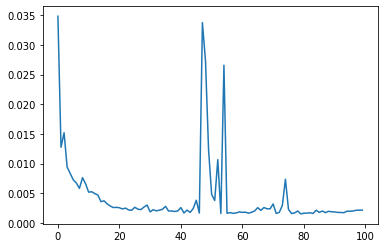

In [7]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=100
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'StockChart/SAMPLE',
    'StockChart/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)


lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )

sess.run(tf.compat.v1.global_variables_initializer())
    
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)
    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))

## eopch : 100 , batchsize : 512 , timesize : 16
## timesize_for_calc_correlation=70
## positive_correlation_stock_num=10
## negative_correlation_sotck_num=10

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 26)
making dataset progress : finished	
result =  Tensor("concat:0", shape=(None, 16, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f993c059750>
Y_2 =  (None, 16, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f980075e850>, <gast.gast.Return object at 0x7f980075e8d0>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f980075e850>, <gast.gast.Return object at 0x7f980075e8d0>]
inputs :  Tensor("rnn_22/transpose_1:0", shape=(None, 16, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 16), dtype=float32)
enco

(22854, 16, 1) (22854, 10, 16, 1) (22854, 10, 16, 1) (22854, 16, 1) (22854, 1)
0.4389531990746036
0.4887442874023691
epoch : 22, t_cost : 0.004221, e_cost : 0.011108, elapsed time : 18.18sec
(53326, 16, 1) (53326, 10, 16, 1) (53326, 10, 16, 1) (53326, 16, 1) (53326, 1)
(22854, 16, 1) (22854, 10, 16, 1) (22854, 10, 16, 1) (22854, 16, 1) (22854, 1)
0.4266018944326788
0.5238424113485962
epoch : 23, t_cost : 0.004102, e_cost : 0.011906, elapsed time : 18.15sec
(53326, 16, 1) (53326, 10, 16, 1) (53326, 10, 16, 1) (53326, 16, 1) (53326, 1)
(22854, 16, 1) (22854, 10, 16, 1) (22854, 10, 16, 1) (22854, 16, 1) (22854, 1)
0.40756306488765404
0.6984819315839559
epoch : 24, t_cost : 0.003919, e_cost : 0.015875, elapsed time : 18.14sec
(53326, 16, 1) (53326, 10, 16, 1) (53326, 10, 16, 1) (53326, 16, 1) (53326, 1)
(22854, 16, 1) (22854, 10, 16, 1) (22854, 10, 16, 1) (22854, 16, 1) (22854, 1)
0.38958932866808027
0.7095197910093702
epoch : 25, t_cost : 0.003746, e_cost : 0.016125, elapsed time : 18.18s

0.2902889607939869
0.05085916898678988
epoch : 52, t_cost : 0.002791, e_cost : 0.001156, elapsed time : 18.15sec
(53326, 16, 1) (53326, 10, 16, 1) (53326, 10, 16, 1) (53326, 16, 1) (53326, 1)
(22854, 16, 1) (22854, 10, 16, 1) (22854, 10, 16, 1) (22854, 16, 1) (22854, 1)
0.2611560341902077
0.05143152244272642
epoch : 53, t_cost : 0.002511, e_cost : 0.001169, elapsed time : 18.17sec
(53326, 16, 1) (53326, 10, 16, 1) (53326, 10, 16, 1) (53326, 16, 1) (53326, 1)
(22854, 16, 1) (22854, 10, 16, 1) (22854, 10, 16, 1) (22854, 16, 1) (22854, 1)
0.2376364751253277
0.05117155646439642
epoch : 54, t_cost : 0.002285, e_cost : 0.001163, elapsed time : 18.18sec
(53326, 16, 1) (53326, 10, 16, 1) (53326, 10, 16, 1) (53326, 16, 1) (53326, 1)
(22854, 16, 1) (22854, 10, 16, 1) (22854, 10, 16, 1) (22854, 16, 1) (22854, 1)
0.220475384616293
0.05313777891569771
epoch : 55, t_cost : 0.002120, e_cost : 0.001208, elapsed time : 18.14sec
(53326, 16, 1) (53326, 10, 16, 1) (53326, 10, 16, 1) (53326, 16, 1) (53326,

(22854, 16, 1) (22854, 10, 16, 1) (22854, 10, 16, 1) (22854, 16, 1) (22854, 1)
0.3679534996044822
0.07954327468178235
epoch : 83, t_cost : 0.003538, e_cost : 0.001808, elapsed time : 18.14sec
(53326, 16, 1) (53326, 10, 16, 1) (53326, 10, 16, 1) (53326, 16, 1) (53326, 1)
(22854, 16, 1) (22854, 10, 16, 1) (22854, 10, 16, 1) (22854, 16, 1) (22854, 1)
0.3991528241895139
0.0733236315427348
epoch : 84, t_cost : 0.003838, e_cost : 0.001666, elapsed time : 18.16sec
(53326, 16, 1) (53326, 10, 16, 1) (53326, 10, 16, 1) (53326, 16, 1) (53326, 1)
(22854, 16, 1) (22854, 10, 16, 1) (22854, 10, 16, 1) (22854, 16, 1) (22854, 1)
0.37764806201448664
0.07931400777306408
epoch : 85, t_cost : 0.003631, e_cost : 0.001803, elapsed time : 18.16sec
(53326, 16, 1) (53326, 10, 16, 1) (53326, 10, 16, 1) (53326, 16, 1) (53326, 1)
(22854, 16, 1) (22854, 10, 16, 1) (22854, 10, 16, 1) (22854, 16, 1) (22854, 1)
0.39777890662662685
0.07279275945620611
epoch : 86, t_cost : 0.003825, e_cost : 0.001654, elapsed time : 18.

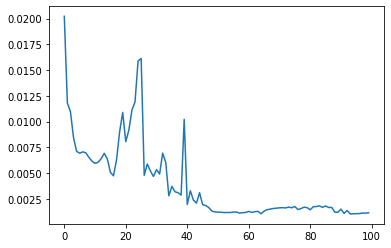

In [8]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=70
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'StockChart/SAMPLE',
    'StockChart/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)


lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )

sess.run(tf.compat.v1.global_variables_initializer())
    
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)
    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))

## eopch : 100 , batchsize : 512 , timesize : 16
## timesize_for_calc_correlation=50
## positive_correlation_stock_num=20
## negative_correlation_sotck_num=20

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 26)
making dataset progress : finished	
result =  Tensor("concat:0", shape=(None, 16, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f97a0107110>
Y_2 =  (None, 16, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f95ec691510>, <gast.gast.Return object at 0x7f95ec691590>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f95ec691510>, <gast.gast.Return object at 0x7f95ec691590>]
inputs :  Tensor("rnn_42/transpose_1:0", shape=(None, 16, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 16), dtype=float32)
enco

(23010, 16, 1) (23010, 20, 16, 1) (23010, 20, 16, 1) (23010, 16, 1) (23010, 1)
0.642349743982777
0.11772239790298045
epoch : 22, t_cost : 0.006176, e_cost : 0.002676, elapsed time : 28.48sec
(53690, 16, 1) (53690, 20, 16, 1) (53690, 20, 16, 1) (53690, 16, 1) (53690, 1)
(23010, 16, 1) (23010, 20, 16, 1) (23010, 20, 16, 1) (23010, 16, 1) (23010, 1)
0.5840946576790884
0.10202237358316779
epoch : 23, t_cost : 0.005616, e_cost : 0.002319, elapsed time : 28.47sec
(53690, 16, 1) (53690, 20, 16, 1) (53690, 20, 16, 1) (53690, 16, 1) (53690, 1)
(23010, 16, 1) (23010, 20, 16, 1) (23010, 20, 16, 1) (23010, 16, 1) (23010, 1)
0.5937431093771011
0.09445119835436344
epoch : 24, t_cost : 0.005709, e_cost : 0.002147, elapsed time : 28.50sec
(53690, 16, 1) (53690, 20, 16, 1) (53690, 20, 16, 1) (53690, 16, 1) (53690, 1)
(23010, 16, 1) (23010, 20, 16, 1) (23010, 20, 16, 1) (23010, 16, 1) (23010, 1)
0.5025269801262766
0.09063495002919808
epoch : 25, t_cost : 0.004832, e_cost : 0.002060, elapsed time : 28.63

0.3272309463354759
0.06045407825149596
epoch : 52, t_cost : 0.003146, e_cost : 0.001374, elapsed time : 28.48sec
(53690, 16, 1) (53690, 20, 16, 1) (53690, 20, 16, 1) (53690, 16, 1) (53690, 1)
(23010, 16, 1) (23010, 20, 16, 1) (23010, 20, 16, 1) (23010, 16, 1) (23010, 1)
0.274137164989952
0.05514737084740773
epoch : 53, t_cost : 0.002636, e_cost : 0.001253, elapsed time : 28.48sec
(53690, 16, 1) (53690, 20, 16, 1) (53690, 20, 16, 1) (53690, 16, 1) (53690, 1)
(23010, 16, 1) (23010, 20, 16, 1) (23010, 20, 16, 1) (23010, 16, 1) (23010, 1)
0.2836278668837622
0.060596253897529095
epoch : 54, t_cost : 0.002727, e_cost : 0.001377, elapsed time : 28.55sec
(53690, 16, 1) (53690, 20, 16, 1) (53690, 20, 16, 1) (53690, 16, 1) (53690, 1)
(23010, 16, 1) (23010, 20, 16, 1) (23010, 20, 16, 1) (23010, 16, 1) (23010, 1)
0.3147086091921665
0.06289770145667717
epoch : 55, t_cost : 0.003026, e_cost : 0.001429, elapsed time : 28.47sec
(53690, 16, 1) (53690, 20, 16, 1) (53690, 20, 16, 1) (53690, 16, 1) (53690

(23010, 16, 1) (23010, 20, 16, 1) (23010, 20, 16, 1) (23010, 16, 1) (23010, 1)
0.14764267578721046
0.04938455281080678
epoch : 83, t_cost : 0.001420, e_cost : 0.001122, elapsed time : 28.43sec
(53690, 16, 1) (53690, 20, 16, 1) (53690, 20, 16, 1) (53690, 16, 1) (53690, 1)
(23010, 16, 1) (23010, 20, 16, 1) (23010, 20, 16, 1) (23010, 16, 1) (23010, 1)
0.14574456750415266
0.05025660147657618
epoch : 84, t_cost : 0.001401, e_cost : 0.001142, elapsed time : 28.51sec
(53690, 16, 1) (53690, 20, 16, 1) (53690, 20, 16, 1) (53690, 16, 1) (53690, 1)
(23010, 16, 1) (23010, 20, 16, 1) (23010, 20, 16, 1) (23010, 16, 1) (23010, 1)
0.142865723464638
0.050671381293796
epoch : 85, t_cost : 0.001374, e_cost : 0.001152, elapsed time : 28.49sec
(53690, 16, 1) (53690, 20, 16, 1) (53690, 20, 16, 1) (53690, 16, 1) (53690, 1)
(23010, 16, 1) (23010, 20, 16, 1) (23010, 20, 16, 1) (23010, 16, 1) (23010, 1)
0.14224091888172552
0.050875721557531506
epoch : 86, t_cost : 0.001368, e_cost : 0.001156, elapsed time : 28.

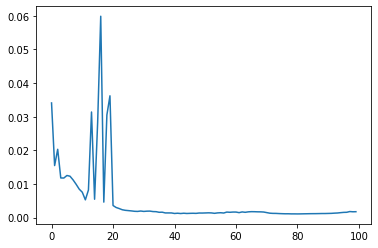

In [13]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=50
positive_correlation_stock_num=20
negative_correlation_sotck_num=20
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'StockChart/SAMPLE',
    'StockChart/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)


lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )

sess.run(tf.compat.v1.global_variables_initializer())
    
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)
    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))

## eopch : 100 , batchsize : 512 , timesize : 16
## timesize_for_calc_correlation=100
## positive_correlation_stock_num=20
## negative_correlation_sotck_num=20

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 26)
making dataset progress : finished	
result =  Tensor("concat:0", shape=(None, 16, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f97a2d4f250>
Y_2 =  (None, 16, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f97a381aa10>, <gast.gast.Return object at 0x7f97a381aa90>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f97a381aa10>, <gast.gast.Return object at 0x7f97a381aa90>]
inputs :  Tensor("rnn_42/transpose_1:0", shape=(None, 16, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 16), dtype=float32)
enco

(22620, 16, 1) (22620, 20, 16, 1) (22620, 20, 16, 1) (22620, 16, 1) (22620, 1)
0.3970908774062991
0.07631834252970293
epoch : 22, t_cost : 0.003855, e_cost : 0.001735, elapsed time : 28.27sec
(52780, 16, 1) (52780, 20, 16, 1) (52780, 20, 16, 1) (52780, 16, 1) (52780, 1)
(22620, 16, 1) (22620, 20, 16, 1) (22620, 20, 16, 1) (22620, 16, 1) (22620, 1)
0.4524360680952668
0.07935253204777837
epoch : 23, t_cost : 0.004393, e_cost : 0.001803, elapsed time : 28.26sec
(52780, 16, 1) (52780, 20, 16, 1) (52780, 20, 16, 1) (52780, 16, 1) (52780, 1)
(22620, 16, 1) (22620, 20, 16, 1) (22620, 20, 16, 1) (22620, 16, 1) (22620, 1)
0.3575139830354601
0.07148340676212683
epoch : 24, t_cost : 0.003471, e_cost : 0.001625, elapsed time : 28.24sec
(52780, 16, 1) (52780, 20, 16, 1) (52780, 20, 16, 1) (52780, 16, 1) (52780, 1)
(22620, 16, 1) (22620, 20, 16, 1) (22620, 20, 16, 1) (22620, 16, 1) (22620, 1)
0.392702215234749
0.06504434969974682
epoch : 25, t_cost : 0.003813, e_cost : 0.001478, elapsed time : 28.23

0.2016881259623915
0.09908750333124772
epoch : 52, t_cost : 0.001958, e_cost : 0.002252, elapsed time : 28.27sec
(52780, 16, 1) (52780, 20, 16, 1) (52780, 20, 16, 1) (52780, 16, 1) (52780, 1)
(22620, 16, 1) (22620, 20, 16, 1) (22620, 20, 16, 1) (22620, 16, 1) (22620, 1)
0.19924331310903654
0.10940159991150722
epoch : 53, t_cost : 0.001934, e_cost : 0.002486, elapsed time : 28.23sec
(52780, 16, 1) (52780, 20, 16, 1) (52780, 20, 16, 1) (52780, 16, 1) (52780, 1)
(22620, 16, 1) (22620, 20, 16, 1) (22620, 20, 16, 1) (22620, 16, 1) (22620, 1)
0.19927340309368446
0.12081452913116664
epoch : 54, t_cost : 0.001935, e_cost : 0.002746, elapsed time : 28.22sec
(52780, 16, 1) (52780, 20, 16, 1) (52780, 20, 16, 1) (52780, 16, 1) (52780, 1)
(22620, 16, 1) (22620, 20, 16, 1) (22620, 20, 16, 1) (22620, 16, 1) (22620, 1)
0.2046571228420362
0.12507671996718273
epoch : 55, t_cost : 0.001987, e_cost : 0.002843, elapsed time : 28.22sec
(52780, 16, 1) (52780, 20, 16, 1) (52780, 20, 16, 1) (52780, 16, 1) (527

(22620, 16, 1) (22620, 20, 16, 1) (22620, 20, 16, 1) (22620, 16, 1) (22620, 1)
0.23494767246302217
0.06402909063035622
epoch : 83, t_cost : 0.002281, e_cost : 0.001455, elapsed time : 28.23sec
(52780, 16, 1) (52780, 20, 16, 1) (52780, 20, 16, 1) (52780, 16, 1) (52780, 1)
(22620, 16, 1) (22620, 20, 16, 1) (22620, 20, 16, 1) (22620, 16, 1) (22620, 1)
0.3231938631506637
0.06214694515801966
epoch : 84, t_cost : 0.003138, e_cost : 0.001412, elapsed time : 28.24sec
(52780, 16, 1) (52780, 20, 16, 1) (52780, 20, 16, 1) (52780, 16, 1) (52780, 1)
(22620, 16, 1) (22620, 20, 16, 1) (22620, 20, 16, 1) (22620, 16, 1) (22620, 1)
0.26958379260031506
0.057685488456627354
epoch : 85, t_cost : 0.002617, e_cost : 0.001311, elapsed time : 28.21sec
(52780, 16, 1) (52780, 20, 16, 1) (52780, 20, 16, 1) (52780, 16, 1) (52780, 1)
(22620, 16, 1) (22620, 20, 16, 1) (22620, 20, 16, 1) (22620, 16, 1) (22620, 1)
0.22319446585606784
0.05411846790229902
epoch : 86, t_cost : 0.002167, e_cost : 0.001230, elapsed time : 

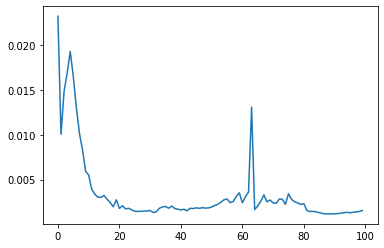

In [14]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=100
positive_correlation_stock_num=20
negative_correlation_sotck_num=20
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'StockChart/SAMPLE',
    'StockChart/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)


lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )

sess.run(tf.compat.v1.global_variables_initializer())
    
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)
    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))

## epoch : 100 , batchsize : 512 , timesize : 16
## timesize_for_calc_correlation=50
## positive_correlation_stock_num=15
## negative_correlation_sotck_num=15

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 26)
making dataset progress : finished	
result =  Tensor("concat:0", shape=(None, 16, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f99303f8490>
Y_2 =  (None, 16, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f98d80a7090>, <gast.gast.Return object at 0x7f98d80a7110>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f98d80a7090>, <gast.gast.Return object at 0x7f98d80a7110>]
inputs :  Tensor("rnn_32/transpose_1:0", shape=(None, 16, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 16), dtype=float32)
enco

(23010, 16, 1) (23010, 15, 16, 1) (23010, 15, 16, 1) (23010, 16, 1) (23010, 1)
0.4537966352654621
0.11831507011083886
epoch : 22, t_cost : 0.004363, e_cost : 0.002689, elapsed time : 23.28sec
(53690, 16, 1) (53690, 15, 16, 1) (53690, 15, 16, 1) (53690, 16, 1) (53690, 1)
(23010, 16, 1) (23010, 15, 16, 1) (23010, 15, 16, 1) (23010, 16, 1) (23010, 1)
0.4399573910050094
0.12869090173626319
epoch : 23, t_cost : 0.004230, e_cost : 0.002925, elapsed time : 23.26sec
(53690, 16, 1) (53690, 15, 16, 1) (53690, 15, 16, 1) (53690, 16, 1) (53690, 1)
(23010, 16, 1) (23010, 15, 16, 1) (23010, 15, 16, 1) (23010, 16, 1) (23010, 1)
0.4197931098751724
0.09457755996845663
epoch : 24, t_cost : 0.004036, e_cost : 0.002149, elapsed time : 23.25sec
(53690, 16, 1) (53690, 15, 16, 1) (53690, 15, 16, 1) (53690, 16, 1) (53690, 1)
(23010, 16, 1) (23010, 15, 16, 1) (23010, 15, 16, 1) (23010, 16, 1) (23010, 1)
0.3812511803698726
0.11209130444331095
epoch : 25, t_cost : 0.003666, e_cost : 0.002548, elapsed time : 23.2

0.3400804592529312
0.05580977333011106
epoch : 52, t_cost : 0.003270, e_cost : 0.001268, elapsed time : 23.27sec
(53690, 16, 1) (53690, 15, 16, 1) (53690, 15, 16, 1) (53690, 16, 1) (53690, 1)
(23010, 16, 1) (23010, 15, 16, 1) (23010, 15, 16, 1) (23010, 16, 1) (23010, 1)
0.35410688701085746
0.056682049413211644
epoch : 53, t_cost : 0.003405, e_cost : 0.001288, elapsed time : 23.25sec
(53690, 16, 1) (53690, 15, 16, 1) (53690, 15, 16, 1) (53690, 16, 1) (53690, 1)
(23010, 16, 1) (23010, 15, 16, 1) (23010, 15, 16, 1) (23010, 16, 1) (23010, 1)
0.35980589140672237
0.06210090609965846
epoch : 54, t_cost : 0.003460, e_cost : 0.001411, elapsed time : 23.24sec
(53690, 16, 1) (53690, 15, 16, 1) (53690, 15, 16, 1) (53690, 16, 1) (53690, 1)
(23010, 16, 1) (23010, 15, 16, 1) (23010, 15, 16, 1) (23010, 16, 1) (23010, 1)
0.3737666032393463
0.062035610259044915
epoch : 55, t_cost : 0.003594, e_cost : 0.001410, elapsed time : 23.25sec
(53690, 16, 1) (53690, 15, 16, 1) (53690, 15, 16, 1) (53690, 16, 1) (5

(23010, 16, 1) (23010, 15, 16, 1) (23010, 15, 16, 1) (23010, 16, 1) (23010, 1)
0.26660183584317565
0.04730717418715358
epoch : 83, t_cost : 0.002563, e_cost : 0.001075, elapsed time : 23.36sec
(53690, 16, 1) (53690, 15, 16, 1) (53690, 15, 16, 1) (53690, 16, 1) (53690, 1)
(23010, 16, 1) (23010, 15, 16, 1) (23010, 15, 16, 1) (23010, 16, 1) (23010, 1)
0.2658363404334523
0.047690072300611064
epoch : 84, t_cost : 0.002556, e_cost : 0.001084, elapsed time : 23.31sec
(53690, 16, 1) (53690, 15, 16, 1) (53690, 15, 16, 1) (53690, 16, 1) (53690, 1)
(23010, 16, 1) (23010, 15, 16, 1) (23010, 15, 16, 1) (23010, 16, 1) (23010, 1)
0.2680463593569584
0.048882179835345596
epoch : 85, t_cost : 0.002577, e_cost : 0.001111, elapsed time : 23.27sec
(53690, 16, 1) (53690, 15, 16, 1) (53690, 15, 16, 1) (53690, 16, 1) (53690, 1)
(23010, 16, 1) (23010, 15, 16, 1) (23010, 15, 16, 1) (23010, 16, 1) (23010, 1)
0.258469047548715
0.04936149754212238
epoch : 86, t_cost : 0.002485, e_cost : 0.001122, elapsed time : 23

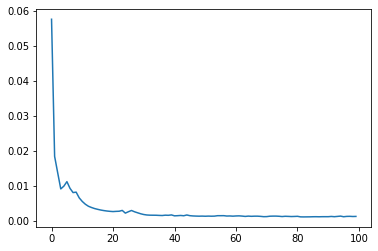

In [17]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=50
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'StockChart/SAMPLE',
    'StockChart/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)


lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )

sess.run(tf.compat.v1.global_variables_initializer())
    
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)
    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))

## epoch : 100 , batchsize : 512 , timesize : 32
## timesize_for_calc_correlation=50
## positive_correlation_stock_num=15
## negative_correlation_sotck_num=15

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 26)
making dataset progress : finished	
result =  Tensor("concat:0", shape=(None, 32, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f97a00dea90>
Y_2 =  (None, 32, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f95ec3ea150>, <gast.gast.Return object at 0x7f95ec3ea1d0>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f95ec3ea150>, <gast.gast.Return object at 0x7f95ec3ea1d0>]
inputs :  Tensor("rnn_32/transpose_1:0", shape=(None, 32, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 32), dtype=float32)
enco

(53690, 32, 1) (53690, 15, 32, 1) (53690, 15, 32, 1) (53690, 32, 1) (53690, 1)
(23010, 32, 1) (23010, 15, 32, 1) (23010, 15, 32, 1) (23010, 32, 1) (23010, 1)
0.6820767989847809
0.1296734128263779
epoch : 22, t_cost : 0.006558, e_cost : 0.002947, elapsed time : 47.44sec
(53690, 32, 1) (53690, 15, 32, 1) (53690, 15, 32, 1) (53690, 32, 1) (53690, 1)
(23010, 32, 1) (23010, 15, 32, 1) (23010, 15, 32, 1) (23010, 32, 1) (23010, 1)
0.7552770113106817
0.1532461559982039
epoch : 23, t_cost : 0.007262, e_cost : 0.003483, elapsed time : 47.44sec
(53690, 32, 1) (53690, 15, 32, 1) (53690, 15, 32, 1) (53690, 32, 1) (53690, 1)
(23010, 32, 1) (23010, 15, 32, 1) (23010, 15, 32, 1) (23010, 32, 1) (23010, 1)
0.8381252905819565
0.12676380935590714
epoch : 24, t_cost : 0.008059, e_cost : 0.002881, elapsed time : 47.35sec
(53690, 32, 1) (53690, 15, 32, 1) (53690, 15, 32, 1) (53690, 32, 1) (53690, 1)
(23010, 32, 1) (23010, 15, 32, 1) (23010, 15, 32, 1) (23010, 32, 1) (23010, 1)
0.8585179480724037
0.1122383450

(23010, 32, 1) (23010, 15, 32, 1) (23010, 15, 32, 1) (23010, 32, 1) (23010, 1)
0.44528619723860174
0.05984331568470225
epoch : 52, t_cost : 0.004282, e_cost : 0.001360, elapsed time : 47.48sec
(53690, 32, 1) (53690, 15, 32, 1) (53690, 15, 32, 1) (53690, 32, 1) (53690, 1)
(23010, 32, 1) (23010, 15, 32, 1) (23010, 15, 32, 1) (23010, 32, 1) (23010, 1)
0.4813807510654442
0.05748129403218627
epoch : 53, t_cost : 0.004629, e_cost : 0.001306, elapsed time : 47.54sec
(53690, 32, 1) (53690, 15, 32, 1) (53690, 15, 32, 1) (53690, 32, 1) (53690, 1)
(23010, 32, 1) (23010, 15, 32, 1) (23010, 15, 32, 1) (23010, 32, 1) (23010, 1)
0.474962760345079
0.056197798578068614
epoch : 54, t_cost : 0.004567, e_cost : 0.001277, elapsed time : 47.41sec
(53690, 32, 1) (53690, 15, 32, 1) (53690, 15, 32, 1) (53690, 32, 1) (53690, 1)
(23010, 32, 1) (23010, 15, 32, 1) (23010, 15, 32, 1) (23010, 32, 1) (23010, 1)
0.402484894846566
0.05614289818913676
epoch : 55, t_cost : 0.003870, e_cost : 0.001276, elapsed time : 47.4

0.27098897320684046
0.060416941792936996
epoch : 82, t_cost : 0.002606, e_cost : 0.001373, elapsed time : 47.44sec
(53690, 32, 1) (53690, 15, 32, 1) (53690, 15, 32, 1) (53690, 32, 1) (53690, 1)
(23010, 32, 1) (23010, 15, 32, 1) (23010, 15, 32, 1) (23010, 32, 1) (23010, 1)
0.30068439937895164
0.06500732284621336
epoch : 83, t_cost : 0.002891, e_cost : 0.001477, elapsed time : 47.37sec
(53690, 32, 1) (53690, 15, 32, 1) (53690, 15, 32, 1) (53690, 32, 1) (53690, 1)
(23010, 32, 1) (23010, 15, 32, 1) (23010, 15, 32, 1) (23010, 32, 1) (23010, 1)
0.34526192012708634
0.08163474392495118
epoch : 84, t_cost : 0.003320, e_cost : 0.001855, elapsed time : 47.41sec
(53690, 32, 1) (53690, 15, 32, 1) (53690, 15, 32, 1) (53690, 32, 1) (53690, 1)
(23010, 32, 1) (23010, 15, 32, 1) (23010, 15, 32, 1) (23010, 32, 1) (23010, 1)
0.34325383411487564
0.08557079551974311
epoch : 85, t_cost : 0.003301, e_cost : 0.001945, elapsed time : 47.35sec
(53690, 32, 1) (53690, 15, 32, 1) (53690, 15, 32, 1) (53690, 32, 1) (

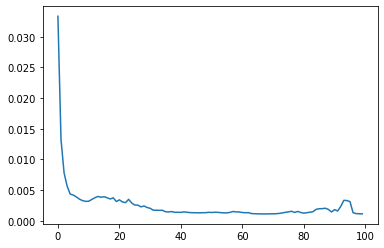

In [18]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=50
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'StockChart/SAMPLE',
    'StockChart/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)


lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )

sess.run(tf.compat.v1.global_variables_initializer())
    
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)
    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))

## epoch : 100 , batchsize : 256 , timesize : 16
## timesize_for_calc_correlation=50
## positive_correlation_stock_num=10
## negative_correlation_sotck_num=10

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 26)
making dataset progress : finished	
result =  Tensor("concat:0", shape=(None, 32, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f97e0270150>
Y_2 =  (None, 32, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f97e0701d90>, <gast.gast.Return object at 0x7f97e0701e10>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f97e0701d90>, <gast.gast.Return object at 0x7f97e0701e10>]
inputs :  Tensor("rnn_22/transpose_1:0", shape=(None, 32, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 32), dtype=float32)
enco

(23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
0.2827337626076769
0.09134975139750168
epoch : 22, t_cost : 0.001353, e_cost : 0.001026, elapsed time : 74.84sec
(53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
(23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
0.2824987618078012
0.09175281252828427
epoch : 23, t_cost : 0.001352, e_cost : 0.001031, elapsed time : 74.87sec
(53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
(23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
0.2818539479339961
0.09145774829084985
epoch : 24, t_cost : 0.001349, e_cost : 0.001028, elapsed time : 74.72sec
(53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
(23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
0.27915414384915493
0.09324105436098762
epoch : 25, t_cost : 0.001336, e_cost : 0.001048, elapsed time : 74.

0.2989069487375673
0.09488945090561174
epoch : 52, t_cost : 0.001430, e_cost : 0.001066, elapsed time : 75.02sec
(53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
(23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
0.30121501747635193
0.09561261205817573
epoch : 53, t_cost : 0.001441, e_cost : 0.001074, elapsed time : 74.84sec
(53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
(23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
0.3028527472051792
0.09476583974901587
epoch : 54, t_cost : 0.001449, e_cost : 0.001065, elapsed time : 75.21sec
(53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
(23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
0.30350956358597614
0.09457943748566322
epoch : 55, t_cost : 0.001452, e_cost : 0.001063, elapsed time : 75.30sec
(53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (536

(23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
0.2856291780481115
0.09737415195559151
epoch : 83, t_cost : 0.001367, e_cost : 0.001094, elapsed time : 74.79sec
(53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
(23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
0.2847959338396322
0.09884478719322942
epoch : 84, t_cost : 0.001363, e_cost : 0.001111, elapsed time : 74.77sec
(53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
(23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
0.2818776932545006
0.09946800870238803
epoch : 85, t_cost : 0.001349, e_cost : 0.001118, elapsed time : 74.78sec
(53690, 32, 1) (53690, 10, 32, 1) (53690, 10, 32, 1) (53690, 32, 1) (53690, 1)
(23010, 32, 1) (23010, 10, 32, 1) (23010, 10, 32, 1) (23010, 32, 1) (23010, 1)
0.2833193568221759
0.10058172486606054
epoch : 86, t_cost : 0.001356, e_cost : 0.001130, elapsed time : 74.7

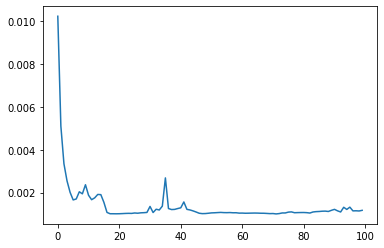

In [20]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=256


kospi=StockData(
    'StockChart/SAMPLE',
    'StockChart/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)


lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )

sess.run(tf.compat.v1.global_variables_initializer())
    
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)
    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))

## eopch : 100 , batchsize : 512 , timesize : 32
## timesize_for_calc_correlation=70
## positive_correlation_stock_num=10
## negative_correlation_sotck_num=10

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 26)
making dataset progress : finished	
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
result =  Tensor("concat:0", shape=(None, 32, 256), dtype=float32)
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
LSTM2 =  <__main__.MI_LSTMCell object at 0x7fb25a415550>
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Y_2 =  (None, 32, 64)
Ple

0.6337922073435038
0.22050843155011535
epoch : 12, t_cost : 0.006094, e_cost : 0.005012, elapsed time : 36.60sec
(53326, 32, 1) (53326, 10, 32, 1) (53326, 10, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 10, 32, 1) (22854, 10, 32, 1) (22854, 32, 1) (22854, 1)
0.5908871733117849
0.25466233293991536
epoch : 13, t_cost : 0.005682, e_cost : 0.005788, elapsed time : 36.50sec
(53326, 32, 1) (53326, 10, 32, 1) (53326, 10, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 10, 32, 1) (22854, 10, 32, 1) (22854, 32, 1) (22854, 1)
0.6618927581002936
0.5035859601921402
epoch : 14, t_cost : 0.006364, e_cost : 0.011445, elapsed time : 36.53sec
(53326, 32, 1) (53326, 10, 32, 1) (53326, 10, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 10, 32, 1) (22854, 10, 32, 1) (22854, 32, 1) (22854, 1)
0.6857718187384307
0.9863089137943462
epoch : 15, t_cost : 0.006594, e_cost : 0.022416, elapsed time : 36.59sec
(53326, 32, 1) (53326, 10, 32, 1) (53326, 10, 32, 1) (53326, 32, 1) (53326, 

(22854, 32, 1) (22854, 10, 32, 1) (22854, 10, 32, 1) (22854, 32, 1) (22854, 1)
0.38931612577289343
0.07321952632628381
epoch : 43, t_cost : 0.003743, e_cost : 0.001664, elapsed time : 36.56sec
(53326, 32, 1) (53326, 10, 32, 1) (53326, 10, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 10, 32, 1) (22854, 10, 32, 1) (22854, 32, 1) (22854, 1)
0.4047078281873837
0.0789140752167441
epoch : 44, t_cost : 0.003891, e_cost : 0.001794, elapsed time : 36.61sec
(53326, 32, 1) (53326, 10, 32, 1) (53326, 10, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 10, 32, 1) (22854, 10, 32, 1) (22854, 32, 1) (22854, 1)
0.35961693967692554
0.0707900132983923
epoch : 45, t_cost : 0.003458, e_cost : 0.001609, elapsed time : 36.56sec
(53326, 32, 1) (53326, 10, 32, 1) (53326, 10, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 10, 32, 1) (22854, 10, 32, 1) (22854, 32, 1) (22854, 1)
0.42965663300128654
0.07946333842119202
epoch : 46, t_cost : 0.004131, e_cost : 0.001806, elapsed time : 36.

0.2831356844981201
0.0635252870270051
epoch : 73, t_cost : 0.002722, e_cost : 0.001444, elapsed time : 36.57sec
(53326, 32, 1) (53326, 10, 32, 1) (53326, 10, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 10, 32, 1) (22854, 10, 32, 1) (22854, 32, 1) (22854, 1)
0.321100854256656
0.07387094822479412
epoch : 74, t_cost : 0.003088, e_cost : 0.001679, elapsed time : 36.45sec
(53326, 32, 1) (53326, 10, 32, 1) (53326, 10, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 10, 32, 1) (22854, 10, 32, 1) (22854, 32, 1) (22854, 1)
0.3230172148323618
0.07334503205493093
epoch : 75, t_cost : 0.003106, e_cost : 0.001667, elapsed time : 36.57sec
(53326, 32, 1) (53326, 10, 32, 1) (53326, 10, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 10, 32, 1) (22854, 10, 32, 1) (22854, 32, 1) (22854, 1)
0.349362040811684
0.06950060703093186
epoch : 76, t_cost : 0.003359, e_cost : 0.001580, elapsed time : 36.53sec
(53326, 32, 1) (53326, 10, 32, 1) (53326, 10, 32, 1) (53326, 32, 1) (53326, 1

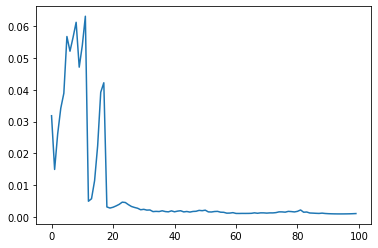

In [9]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=70
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'StockChart/SAMPLE',
    'StockChart/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)


lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )

sess.run(tf.compat.v1.global_variables_initializer())
    
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)
    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

## eopch : 100 , batchsize : 512 , timesize : 32
## timesize_for_calc_correlation=100
## positive_correlation_stock_num=10
## negative_correlation_sotck_num=10

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 26)
making dataset progress : finished	
result =  Tensor("concat:0", shape=(None, 32, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7fb270064250>
Y_2 =  (None, 32, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7fb280717510>, <gast.gast.Return object at 0x7fb2807174d0>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7fb280717510>, <gast.gast.Return object at 0x7fb2807174d0>]
inputs :  Tensor("rnn_22/transpose_1:0", shape=(None, 32, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 32), dtype=float32)
enco

(22620, 32, 1) (22620, 10, 32, 1) (22620, 10, 32, 1) (22620, 32, 1) (22620, 1)
0.6556845598388463
0.09665561158908531
epoch : 22, t_cost : 0.006366, e_cost : 0.002197, elapsed time : 36.31sec
(52780, 32, 1) (52780, 10, 32, 1) (52780, 10, 32, 1) (52780, 32, 1) (52780, 1)
(22620, 32, 1) (22620, 10, 32, 1) (22620, 10, 32, 1) (22620, 32, 1) (22620, 1)
0.5975310441572219
0.10035593167413026
epoch : 23, t_cost : 0.005801, e_cost : 0.002281, elapsed time : 36.29sec
(52780, 32, 1) (52780, 10, 32, 1) (52780, 10, 32, 1) (52780, 32, 1) (52780, 1)
(22620, 32, 1) (22620, 10, 32, 1) (22620, 10, 32, 1) (22620, 32, 1) (22620, 1)
0.63969708874356
0.12298344750888646
epoch : 24, t_cost : 0.006211, e_cost : 0.002795, elapsed time : 36.33sec
(52780, 32, 1) (52780, 10, 32, 1) (52780, 10, 32, 1) (52780, 32, 1) (52780, 1)
(22620, 32, 1) (22620, 10, 32, 1) (22620, 10, 32, 1) (22620, 32, 1) (22620, 1)
0.6099641065811738
0.08504412963520736
epoch : 25, t_cost : 0.005922, e_cost : 0.001933, elapsed time : 36.37s

0.15605968446470797
0.0473141226102598
epoch : 52, t_cost : 0.001515, e_cost : 0.001075, elapsed time : 36.40sec
(52780, 32, 1) (52780, 10, 32, 1) (52780, 10, 32, 1) (52780, 32, 1) (52780, 1)
(22620, 32, 1) (22620, 10, 32, 1) (22620, 10, 32, 1) (22620, 32, 1) (22620, 1)
0.14899635582696646
0.04682387973298319
epoch : 53, t_cost : 0.001447, e_cost : 0.001064, elapsed time : 36.30sec
(52780, 32, 1) (52780, 10, 32, 1) (52780, 10, 32, 1) (52780, 32, 1) (52780, 1)
(22620, 32, 1) (22620, 10, 32, 1) (22620, 10, 32, 1) (22620, 32, 1) (22620, 1)
0.14490582945290953
0.04611859208671376
epoch : 54, t_cost : 0.001407, e_cost : 0.001048, elapsed time : 36.39sec
(52780, 32, 1) (52780, 10, 32, 1) (52780, 10, 32, 1) (52780, 32, 1) (52780, 1)
(22620, 32, 1) (22620, 10, 32, 1) (22620, 10, 32, 1) (22620, 32, 1) (22620, 1)
0.14270434202626348
0.04533540635020472
epoch : 55, t_cost : 0.001385, e_cost : 0.001030, elapsed time : 36.34sec
(52780, 32, 1) (52780, 10, 32, 1) (52780, 10, 32, 1) (52780, 32, 1) (52

(22620, 32, 1) (22620, 10, 32, 1) (22620, 10, 32, 1) (22620, 32, 1) (22620, 1)
0.3715613891254179
0.11805728328181431
epoch : 83, t_cost : 0.003607, e_cost : 0.002683, elapsed time : 36.29sec
(52780, 32, 1) (52780, 10, 32, 1) (52780, 10, 32, 1) (52780, 32, 1) (52780, 1)
(22620, 32, 1) (22620, 10, 32, 1) (22620, 10, 32, 1) (22620, 32, 1) (22620, 1)
0.3703792238375172
0.09050767921144143
epoch : 84, t_cost : 0.003596, e_cost : 0.002057, elapsed time : 36.31sec
(52780, 32, 1) (52780, 10, 32, 1) (52780, 10, 32, 1) (52780, 32, 1) (52780, 1)
(22620, 32, 1) (22620, 10, 32, 1) (22620, 10, 32, 1) (22620, 32, 1) (22620, 1)
0.548918385640718
0.0812941919430159
epoch : 85, t_cost : 0.005329, e_cost : 0.001848, elapsed time : 36.40sec
(52780, 32, 1) (52780, 10, 32, 1) (52780, 10, 32, 1) (52780, 32, 1) (52780, 1)
(22620, 32, 1) (22620, 10, 32, 1) (22620, 10, 32, 1) (22620, 32, 1) (22620, 1)
0.46314163465285674
0.08583455620100722
epoch : 86, t_cost : 0.004497, e_cost : 0.001951, elapsed time : 36.43

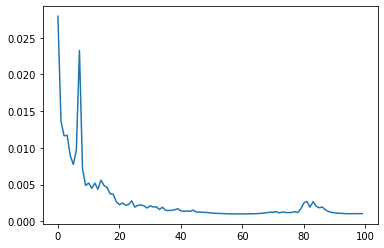

In [10]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=100
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'StockChart/SAMPLE',
    'StockChart/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)


lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )

sess.run(tf.compat.v1.global_variables_initializer())
    
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)
    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

## eopch : 100 , batchsize : 512 , timesize : 64
## timesize_for_calc_correlation=100
## positive_correlation_stock_num=10
## negative_correlation_sotck_num=10

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 26)
making dataset progress : finished	
result =  Tensor("concat:0", shape=(None, 64, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7fb21c766250>
Y_2 =  (None, 64, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7fb064966c90>, <gast.gast.Return object at 0x7fb064966d10>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7fb064966c90>, <gast.gast.Return object at 0x7fb064966d10>]
inputs :  Tensor("rnn_22/transpose_1:0", shape=(None, 64, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 64), dtype=float32)
enco

(52780, 64, 1) (52780, 10, 64, 1) (52780, 10, 64, 1) (52780, 64, 1) (52780, 1)
(22620, 64, 1) (22620, 10, 64, 1) (22620, 10, 64, 1) (22620, 64, 1) (22620, 1)
0.204020525154192
0.11663190450053662
epoch : 22, t_cost : 0.001981, e_cost : 0.002651, elapsed time : 86.01sec
(52780, 64, 1) (52780, 10, 64, 1) (52780, 10, 64, 1) (52780, 64, 1) (52780, 1)
(22620, 64, 1) (22620, 10, 64, 1) (22620, 10, 64, 1) (22620, 64, 1) (22620, 1)
0.2020382810733281
0.11291219497798011
epoch : 23, t_cost : 0.001962, e_cost : 0.002566, elapsed time : 86.28sec
(52780, 64, 1) (52780, 10, 64, 1) (52780, 10, 64, 1) (52780, 64, 1) (52780, 1)
(22620, 64, 1) (22620, 10, 64, 1) (22620, 10, 64, 1) (22620, 64, 1) (22620, 1)
0.20155213947873563
0.10672031121794134
epoch : 24, t_cost : 0.001957, e_cost : 0.002425, elapsed time : 86.02sec
(52780, 64, 1) (52780, 10, 64, 1) (52780, 10, 64, 1) (52780, 64, 1) (52780, 1)
(22620, 64, 1) (22620, 10, 64, 1) (22620, 10, 64, 1) (22620, 64, 1) (22620, 1)
0.20320711977547035
0.0943643

(22620, 64, 1) (22620, 10, 64, 1) (22620, 10, 64, 1) (22620, 64, 1) (22620, 1)
0.2114833418163471
0.05747213467839174
epoch : 52, t_cost : 0.002053, e_cost : 0.001306, elapsed time : 86.07sec
(52780, 64, 1) (52780, 10, 64, 1) (52780, 10, 64, 1) (52780, 64, 1) (52780, 1)
(22620, 64, 1) (22620, 10, 64, 1) (22620, 10, 64, 1) (22620, 64, 1) (22620, 1)
0.22870358568616211
0.0604003545595333
epoch : 53, t_cost : 0.002220, e_cost : 0.001373, elapsed time : 86.16sec
(52780, 64, 1) (52780, 10, 64, 1) (52780, 10, 64, 1) (52780, 64, 1) (52780, 1)
(22620, 64, 1) (22620, 10, 64, 1) (22620, 10, 64, 1) (22620, 64, 1) (22620, 1)
0.22520068188896403
0.05434630380477756
epoch : 54, t_cost : 0.002186, e_cost : 0.001235, elapsed time : 86.12sec
(52780, 64, 1) (52780, 10, 64, 1) (52780, 10, 64, 1) (52780, 64, 1) (52780, 1)
(22620, 64, 1) (22620, 10, 64, 1) (22620, 10, 64, 1) (22620, 64, 1) (22620, 1)
0.19938171794638038
0.05076565843774006
epoch : 55, t_cost : 0.001936, e_cost : 0.001154, elapsed time : 85

0.19102734426269308
0.06239207382895984
epoch : 82, t_cost : 0.001855, e_cost : 0.001418, elapsed time : 86.17sec
(52780, 64, 1) (52780, 10, 64, 1) (52780, 10, 64, 1) (52780, 64, 1) (52780, 1)
(22620, 64, 1) (22620, 10, 64, 1) (22620, 10, 64, 1) (22620, 64, 1) (22620, 1)
0.27169660839717835
0.05661044688895345
epoch : 83, t_cost : 0.002638, e_cost : 0.001287, elapsed time : 85.86sec
(52780, 64, 1) (52780, 10, 64, 1) (52780, 10, 64, 1) (52780, 64, 1) (52780, 1)
(22620, 64, 1) (22620, 10, 64, 1) (22620, 10, 64, 1) (22620, 64, 1) (22620, 1)
0.14939255599165335
0.05543925490928814
epoch : 84, t_cost : 0.001450, e_cost : 0.001260, elapsed time : 86.25sec
(52780, 64, 1) (52780, 10, 64, 1) (52780, 10, 64, 1) (52780, 64, 1) (52780, 1)
(22620, 64, 1) (22620, 10, 64, 1) (22620, 10, 64, 1) (22620, 64, 1) (22620, 1)
0.16170451528159901
0.058264264167519286
epoch : 85, t_cost : 0.001570, e_cost : 0.001324, elapsed time : 86.12sec
(52780, 64, 1) (52780, 10, 64, 1) (52780, 10, 64, 1) (52780, 64, 1) (

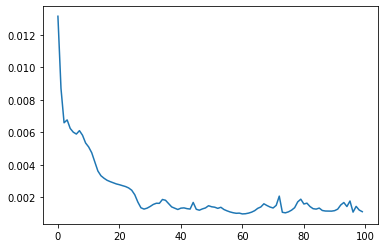

In [11]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=64
timesize_for_calc_correlation=100
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'StockChart/SAMPLE',
    'StockChart/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)


lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )

sess.run(tf.compat.v1.global_variables_initializer())
    
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)
    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

In [ ]:
class StockData():
    """
        훈련용 데이터세트와 평가용 데이터세트를 만들기 위한 과정.

        파라미터:
            folderPath : 종목시장의 주가 csv가 저장되어있는 디렉토리 경로.
            indexPath : 종목시장의 인덱스 주 csv파일의 경로.
            timewindowsize : LSTM의 입력으로 들어가는 타임의 사이즈. 10일 경우 미래주가를 예측하기 위해 이전 10일 주가를 사용.
            windowsizeForPCC : PCC를 계산하기 위해 사용되는 타임의 사이즈. 10일 경우 관계주를 구하기 위해 이전 10일 주가를 사용.
            PositiveStockNumber : 긍정관계주 개수.
            NegativeStockNumber : 부정관계주 개수.
            train_test_rate : 훈련:평가 세트 비율. 0.7일 경우 생성된 데이터 세트중 70%는 훈련용, 30%는 평가용으로 사용.
            batchSize : 세트를 나누는 배치 사이즈.

        과정:
            종목시장의 모든 종목의 시가와 인덱스 시가를 읽어옴.
            minmax스케일러를 각 종목과 인덱스에 적용하고 저장.
            PCC계산, 관계주 계산.
            데이터세트 저장.
               
    """
    def __init__(self,folderPath,indexPath,timewindowsize,windowsizeForPCC,PostiveStockNumber,NegativeStockNumber,train_test_rate,batchSize):        
               
        if(train_test_rate<=0 or train_test_rate>=1):
            raise ValueError('train_test_rate should be between 0 and 1')        
        self.P=PostiveStockNumber
        self.N=NegativeStockNumber        
        self.T=timewindowsize
        self.Tr=windowsizeForPCC
        self.folderPath = folderPath      
        self.indexPath=indexPath    
        self.batchSize=batchSize
        self.date_duration=3000
        
        self.train_test_rate=train_test_rate
        self.scaler=MinMaxScaler(feature_range=(-1,1))  
        self.indexScaler = MinMaxScaler(feature_range=(-1,1))

        self.indexPrice = self.loadIndex()
        self.stockPrice = self.loadCSV()

        self.trainSet,self.testSet=self.make_dataset()

        self.batchNum={}
    
    def getBatch(self,option):
        """
        클래스에 저장된 세트를 y,xp,xn,xi,target으로 나누고 batch생성.

        args:
            option='training' or 'evaluation'

        returns:
            batch 제너레이터
            batch={'y','xp','xn','xi','target'}
        """
        if(option is not 'training' and option is not 'evaluation'):
            raise ValueError('option should be "training" or "evaluation".')

        if(option is 'training'):
            returnSet = self.trainSet
        else:
            returnSet = self.testSet
        
        y=[]
        xp=[]
        xn=[]
        xi=[]
        target=[]

        for d in returnSet:
            y.append(d['target_history'])  
            xp.append(d['pos_history'])       
            xn.append(d['neg_history'])       
            xi.append(d['index_history'])       
            target.append(d['target_price'])             
        y=np.reshape(y,(-1,self.T,1))
        xp=np.reshape(xp,(-1,10,self.T,1))
        xn=np.reshape(xn,(-1,10,self.T,1))
        xi=np.reshape(xi,(-1,self.T,1))
        target=np.reshape(target,(-1,1))

        print(y.shape,xp.shape,xn.shape,xi.shape,target.shape)     

        batchNum=int(len(y)/self.batchSize)
        self.batchNum[option]=batchNum

        for i in range(batchNum):
            yield {'y':y[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xp':xp[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xn':xn[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xi':xi[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'target':target[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32)}

    def loadCSV(self):
        """
        csv파일이 있는 폴더를 입력으로 받아 데이터를 읽어옴.
        """
        csvList=os.listdir(self.folderPath)        
        dataframe = pd.DataFrame([])
        

        for csv in csvList:
            data=pd.read_csv(self.folderPath+'/'+csv,engine='python')
            if(len(data)>self.date_duration):
                data=data[-self.date_duration-1:-1]
                data=data.reset_index()
                data=data['open']

                dataframe=dataframe.append(data,ignore_index=True)
        dataT=np.array(dataframe).T
        self.scaler.fit(dataT)
        dataT=self.scaler.transform(dataT)
        dataT=dataT.T
        dataframe=pd.DataFrame(dataT)
        dataframe=dataframe.transpose()
        print('StockPrice shape: ',dataframe.shape)
        return dataframe
    
    def loadIndex(self):
        data=pd.read_csv(self.indexPath,engine='python')
        data=data[-self.date_duration-1:-1]        
        data=data.reset_index()
        data=data.fillna(method='ffill')

        data=np.array(data['Open'])
        data=np.reshape(data,(-1,1))

        data=self.indexScaler.fit_transform(data)

        data=pd.DataFrame(np.squeeze(data))        

        print('IndexPrice shape: ',data.shape)
        return data 


    def make_dataset(self):
        """
        예측모델에 사용되는 입력,타겟 데이터세트.
        입력데이터의 shape는 (목표주식+관계주식+인덱스, 타임윈도우사이즈)
        타겟데이터의 shape는 (1,1)
        """
        maxday=max([self.T,self.Tr])
        dataset=[]

        for i in range(maxday,len(self.stockPrice)):
            print('making dataset progress : {}/{}'.format(i,len(self.stockPrice)),end='\r')
            priceSet=self.stockPrice.loc[i-self.T:i-1]
            targetSet=self.stockPrice.loc[i]
            positiveSet,negativeSet=self.calculate_correlation(self.stockPrice.loc[i-maxday:i-1])
            indexSet = self.indexPrice.loc[i-self.T:i-1]

            for targetNum in priceSet.columns:
                target_history=np.reshape(np.array(priceSet[targetNum]),(self.T,1))
                pos_history=np.reshape(np.array(positiveSet[targetNum].T),(10,self.T,1))
                neg_history=np.reshape(np.array(negativeSet[targetNum].T),(10,self.T,1))
                index_history=np.reshape(np.array(indexSet),(self.T,1))
                target_price=np.reshape(np.array(targetSet[targetNum]),(1,1))

                dataset.append({'target_history':target_history,
                                'pos_history':pos_history,
                                'neg_history':neg_history,
                                'index_history':index_history,
                                'target_price':target_price
                            })
        print('making dataset progress : finished\t')
        
        return dataset[:int(len(dataset)*self.train_test_rate)],dataset[int(len(dataset)*self.train_test_rate):]

    def calculate_correlation(self,priceSet):
        """
        Pearson Correlation Coefficient(PCC)를 계산하고,
        높은순으로 긍정관계주, 낮은순으로 부정관계주를 설정한 개수만큼 생성하여 리스트에 저장한후, 리턴.
        입력은 전체 종목의 타임윈도우간의 주가.

        Returns:
            #모든종목의 관계주. 
            긍정관계주 shape = (종목 수, dataframe(T*P))
            부정관계주 shape = (종목 수, dataframe(T*N))
        """    
        positive=[]
        negative=[] 
        corr=priceSet[-self.Tr:].corr(method='pearson')

        for i in corr.columns:
            tempCorr=corr[i].sort_values(ascending=False)
            index_P=tempCorr[1:self.P+1].index
            index_N=tempCorr[-self.N:].index
            
            priceSet=priceSet[-self.T:]
            posSet=priceSet[index_P]
            negSet=priceSet[index_N]
            posSet.columns=range(self.P)
            negSet.columns=range(self.N)
            
            positive.append(posSet)
            negative.append(negSet)
        return positive,negative

            
"""testLine
kospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)
print(np.shape(kospi.trainSet))
print(np.shape(kospi.testSet))
"""


## eopch : 100 , batchsize : 128 , timesize : 32
## timesize_for_calc_correlation=70
## positive_correlation_stock_num=10
## negative_correlation_sotck_num=10

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 26)
making dataset progress : finished	
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
result =  Tensor("concat:0", shape=(None, 32, 256), dtype=float32)
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f7d98bd2650>
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Y_2 =  (None, 32, 64)
Ple

0.6282932690810412
0.313018365734024
epoch : 12, t_cost : 0.001510, e_cost : 0.001759, elapsed time : 145.58sec
(53326, 32, 1) (53326, 10, 32, 1) (53326, 10, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 10, 32, 1) (22854, 10, 32, 1) (22854, 32, 1) (22854, 1)
0.622389111405937
0.31466367532266304
epoch : 13, t_cost : 0.001496, e_cost : 0.001768, elapsed time : 145.65sec
(53326, 32, 1) (53326, 10, 32, 1) (53326, 10, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 10, 32, 1) (22854, 10, 32, 1) (22854, 32, 1) (22854, 1)
0.6148475827649236
0.3024251922615804
epoch : 14, t_cost : 0.001478, e_cost : 0.001699, elapsed time : 145.63sec
(53326, 32, 1) (53326, 10, 32, 1) (53326, 10, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 10, 32, 1) (22854, 10, 32, 1) (22854, 32, 1) (22854, 1)
0.5910741550032981
0.324887030874379
epoch : 15, t_cost : 0.001421, e_cost : 0.001825, elapsed time : 145.50sec
(53326, 32, 1) (53326, 10, 32, 1) (53326, 10, 32, 1) (53326, 32, 1) (53326, 

(22854, 32, 1) (22854, 10, 32, 1) (22854, 10, 32, 1) (22854, 32, 1) (22854, 1)
0.5700857864576392
0.2892017929989379
epoch : 43, t_cost : 0.001370, e_cost : 0.001625, elapsed time : 145.42sec
(53326, 32, 1) (53326, 10, 32, 1) (53326, 10, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 10, 32, 1) (22854, 10, 32, 1) (22854, 32, 1) (22854, 1)
0.5700739669555333
0.29092450052849017
epoch : 44, t_cost : 0.001370, e_cost : 0.001634, elapsed time : 145.81sec
(53326, 32, 1) (53326, 10, 32, 1) (53326, 10, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 10, 32, 1) (22854, 10, 32, 1) (22854, 32, 1) (22854, 1)
0.567634438542882
0.2958149063924793
epoch : 45, t_cost : 0.001365, e_cost : 0.001662, elapsed time : 145.60sec
(53326, 32, 1) (53326, 10, 32, 1) (53326, 10, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 10, 32, 1) (22854, 10, 32, 1) (22854, 32, 1) (22854, 1)
0.5691293529816903
0.2911948067485355
epoch : 46, t_cost : 0.001368, e_cost : 0.001636, elapsed time : 145.4

0.6007071118510794
0.19943094748305157
epoch : 73, t_cost : 0.001444, e_cost : 0.001120, elapsed time : 145.57sec
(53326, 32, 1) (53326, 10, 32, 1) (53326, 10, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 10, 32, 1) (22854, 10, 32, 1) (22854, 32, 1) (22854, 1)
0.6161353696952574
0.19680769805563614
epoch : 74, t_cost : 0.001481, e_cost : 0.001106, elapsed time : 145.67sec
(53326, 32, 1) (53326, 10, 32, 1) (53326, 10, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 10, 32, 1) (22854, 10, 32, 1) (22854, 32, 1) (22854, 1)
0.610114244162105
0.20185274857794866
epoch : 75, t_cost : 0.001467, e_cost : 0.001134, elapsed time : 145.64sec
(53326, 32, 1) (53326, 10, 32, 1) (53326, 10, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 10, 32, 1) (22854, 10, 32, 1) (22854, 32, 1) (22854, 1)
0.6465395965788048
0.21062013891059905
epoch : 76, t_cost : 0.001554, e_cost : 0.001183, elapsed time : 146.59sec
(53326, 32, 1) (53326, 10, 32, 1) (53326, 10, 32, 1) (53326, 32, 1) (53

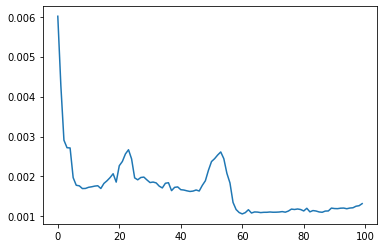

In [8]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=70
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=128


kospi=StockData(
    'StockChart/SAMPLE',
    'StockChart/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)


lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )

sess.run(tf.compat.v1.global_variables_initializer())
    
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)
    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

## eopch : 100 , batchsize : 512 , timesize : 32
## timesize_for_calc_correlation=70
## positive_correlation_stock_num=15
## negative_correlation_sotck_num=15

In [6]:
class StockData():
    """
        훈련용 데이터세트와 평가용 데이터세트를 만들기 위한 과정.

        파라미터:
            folderPath : 종목시장의 주가 csv가 저장되어있는 디렉토리 경로.
            indexPath : 종목시장의 인덱스 주 csv파일의 경로.
            timewindowsize : LSTM의 입력으로 들어가는 타임의 사이즈. 10일 경우 미래주가를 예측하기 위해 이전 10일 주가를 사용.
            windowsizeForPCC : PCC를 계산하기 위해 사용되는 타임의 사이즈. 10일 경우 관계주를 구하기 위해 이전 10일 주가를 사용.
            PositiveStockNumber : 긍정관계주 개수.
            NegativeStockNumber : 부정관계주 개수.
            train_test_rate : 훈련:평가 세트 비율. 0.7일 경우 생성된 데이터 세트중 70%는 훈련용, 30%는 평가용으로 사용.
            batchSize : 세트를 나누는 배치 사이즈.

        과정:
            종목시장의 모든 종목의 시가와 인덱스 시가를 읽어옴.
            minmax스케일러를 각 종목과 인덱스에 적용하고 저장.
            PCC계산, 관계주 계산.
            데이터세트 저장.
               
    """
    def __init__(self,folderPath,indexPath,timewindowsize,windowsizeForPCC,PostiveStockNumber,NegativeStockNumber,train_test_rate,batchSize):        
               
        if(train_test_rate<=0 or train_test_rate>=1):
            raise ValueError('train_test_rate should be between 0 and 1')        
        self.P=PostiveStockNumber
        self.N=NegativeStockNumber        
        self.T=timewindowsize
        self.Tr=windowsizeForPCC
        self.folderPath = folderPath      
        self.indexPath=indexPath    
        self.batchSize=batchSize
        self.date_duration=3000
        
        self.train_test_rate=train_test_rate
        self.scaler=MinMaxScaler(feature_range=(-1,1))  
        self.indexScaler = MinMaxScaler(feature_range=(-1,1))

        self.indexPrice = self.loadIndex()
        self.stockPrice = self.loadCSV()

        self.trainSet,self.testSet=self.make_dataset()

        self.batchNum={}
    
    def getBatch(self,option):
        """
        클래스에 저장된 세트를 y,xp,xn,xi,target으로 나누고 batch생성.

        args:
            option='training' or 'evaluation'

        returns:
            batch 제너레이터
            batch={'y','xp','xn','xi','target'}
        """
        if(option is not 'training' and option is not 'evaluation'):
            raise ValueError('option should be "training" or "evaluation".')

        if(option is 'training'):
            returnSet = self.trainSet
        else:
            returnSet = self.testSet
        
        y=[]
        xp=[]
        xn=[]
        xi=[]
        target=[]

        for d in returnSet:
            y.append(d['target_history'])  
            xp.append(d['pos_history'])       
            xn.append(d['neg_history'])       
            xi.append(d['index_history'])       
            target.append(d['target_price'])             
        y=np.reshape(y,(-1,self.T,1))
        xp=np.reshape(xp,(-1,15,self.T,1))
        xn=np.reshape(xn,(-1,15,self.T,1))
        xi=np.reshape(xi,(-1,self.T,1))
        target=np.reshape(target,(-1,1))

        print(y.shape,xp.shape,xn.shape,xi.shape,target.shape)     

        batchNum=int(len(y)/self.batchSize)
        self.batchNum[option]=batchNum

        for i in range(batchNum):
            yield {'y':y[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xp':xp[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xn':xn[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xi':xi[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'target':target[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32)}

    def loadCSV(self):
        """
        csv파일이 있는 폴더를 입력으로 받아 데이터를 읽어옴.
        """
        csvList=os.listdir(self.folderPath)        
        dataframe = pd.DataFrame([])
        

        for csv in csvList:
            data=pd.read_csv(self.folderPath+'/'+csv,engine='python')
            if(len(data)>self.date_duration):
                data=data[-self.date_duration-1:-1]
                data=data.reset_index()
                data=data['open']

                dataframe=dataframe.append(data,ignore_index=True)
        dataT=np.array(dataframe).T
        self.scaler.fit(dataT)
        dataT=self.scaler.transform(dataT)
        dataT=dataT.T
        dataframe=pd.DataFrame(dataT)
        dataframe=dataframe.transpose()
        print('StockPrice shape: ',dataframe.shape)
        return dataframe
    
    def loadIndex(self):
        data=pd.read_csv(self.indexPath,engine='python')
        data=data[-self.date_duration-1:-1]        
        data=data.reset_index()
        data=data.fillna(method='ffill')

        data=np.array(data['Open'])
        data=np.reshape(data,(-1,1))

        data=self.indexScaler.fit_transform(data)

        data=pd.DataFrame(np.squeeze(data))        

        print('IndexPrice shape: ',data.shape)
        return data 


    def make_dataset(self):
        """
        예측모델에 사용되는 입력,타겟 데이터세트.
        입력데이터의 shape는 (목표주식+관계주식+인덱스, 타임윈도우사이즈)
        타겟데이터의 shape는 (1,1)
        """
        maxday=max([self.T,self.Tr])
        dataset=[]

        for i in range(maxday,len(self.stockPrice)):
            print('making dataset progress : {}/{}'.format(i,len(self.stockPrice)),end='\r')
            priceSet=self.stockPrice.loc[i-self.T:i-1]
            targetSet=self.stockPrice.loc[i]
            positiveSet,negativeSet=self.calculate_correlation(self.stockPrice.loc[i-maxday:i-1])
            indexSet = self.indexPrice.loc[i-self.T:i-1]

            for targetNum in priceSet.columns:
                target_history=np.reshape(np.array(priceSet[targetNum]),(self.T,1))
                pos_history=np.reshape(np.array(positiveSet[targetNum].T),(15,self.T,1))
                neg_history=np.reshape(np.array(negativeSet[targetNum].T),(15,self.T,1))
                index_history=np.reshape(np.array(indexSet),(self.T,1))
                target_price=np.reshape(np.array(targetSet[targetNum]),(1,1))

                dataset.append({'target_history':target_history,
                                'pos_history':pos_history,
                                'neg_history':neg_history,
                                'index_history':index_history,
                                'target_price':target_price
                            })
        print('making dataset progress : finished\t')
        
        return dataset[:int(len(dataset)*self.train_test_rate)],dataset[int(len(dataset)*self.train_test_rate):]

    def calculate_correlation(self,priceSet):
        """
        Pearson Correlation Coefficient(PCC)를 계산하고,
        높은순으로 긍정관계주, 낮은순으로 부정관계주를 설정한 개수만큼 생성하여 리스트에 저장한후, 리턴.
        입력은 전체 종목의 타임윈도우간의 주가.

        Returns:
            #모든종목의 관계주. 
            긍정관계주 shape = (종목 수, dataframe(T*P))
            부정관계주 shape = (종목 수, dataframe(T*N))
        """    
        positive=[]
        negative=[] 
        corr=priceSet[-self.Tr:].corr(method='pearson')

        for i in corr.columns:
            tempCorr=corr[i].sort_values(ascending=False)
            index_P=tempCorr[1:self.P+1].index
            index_N=tempCorr[-self.N:].index
            
            priceSet=priceSet[-self.T:]
            posSet=priceSet[index_P]
            negSet=priceSet[index_N]
            posSet.columns=range(self.P)
            negSet.columns=range(self.N)
            
            positive.append(posSet)
            negative.append(negSet)
        return positive,negative

            
"""testLine
kospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)
print(np.shape(kospi.trainSet))
print(np.shape(kospi.testSet))
"""


"testLine\nkospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)\nprint(np.shape(kospi.trainSet))\nprint(np.shape(kospi.testSet))\n"

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 26)
making dataset progress : finished	
result =  Tensor("concat:0", shape=(None, 32, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f7d997a4710>
Y_2 =  (None, 32, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7f14089dd0>, <gast.gast.Return object at 0x7f7f14089e50>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7f14089dd0>, <gast.gast.Return object at 0x7f7f14089e50>]
inputs :  Tensor("rnn_32/transpose_1:0", shape=(None, 32, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 32), dtype=float32)
enco

(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.452756657905411
0.0959632929880172
epoch : 22, t_cost : 0.004353, e_cost : 0.002181, elapsed time : 47.58sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.45446169981732965
0.08371365361381322
epoch : 23, t_cost : 0.004370, e_cost : 0.001903, elapsed time : 47.25sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.451231989543885
0.07710750197293237
epoch : 24, t_cost : 0.004339, e_cost : 0.001752, elapsed time : 48.09sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.3990418131579645
0.0740950309

(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.29947486234596
0.05984152675955556
epoch : 52, t_cost : 0.002880, e_cost : 0.001360, elapsed time : 47.07sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.2711600332404487
0.06262072586105205
epoch : 53, t_cost : 0.002607, e_cost : 0.001423, elapsed time : 47.03sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.2005977178341709
0.057463072531390935
epoch : 54, t_cost : 0.001929, e_cost : 0.001306, elapsed time : 47.15sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.2348960061208345
0.05564598127966747
epoch : 55, t_cost : 0.002259, e_cost : 0.001265, elapsed time : 47.56

0.1793768245843239
0.044929633411811665
epoch : 82, t_cost : 0.001725, e_cost : 0.001021, elapsed time : 47.08sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.15210920030949637
0.04365478432737291
epoch : 83, t_cost : 0.001463, e_cost : 0.000992, elapsed time : 47.13sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.1399036458460614
0.043536741606658325
epoch : 84, t_cost : 0.001345, e_cost : 0.000989, elapsed time : 47.09sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.1370145695982501
0.043153610138688236
epoch : 85, t_cost : 0.001317, e_cost : 0.000981, elapsed time : 47.05sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (5

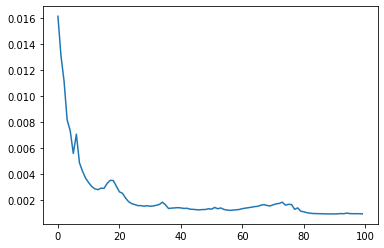

In [10]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=70
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'StockChart/SAMPLE',
    'StockChart/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)


lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )

sess.run(tf.compat.v1.global_variables_initializer())
    
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)
    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

In [11]:
class StockData():
    """
        훈련용 데이터세트와 평가용 데이터세트를 만들기 위한 과정.

        파라미터:
            folderPath : 종목시장의 주가 csv가 저장되어있는 디렉토리 경로.
            indexPath : 종목시장의 인덱스 주 csv파일의 경로.
            timewindowsize : LSTM의 입력으로 들어가는 타임의 사이즈. 10일 경우 미래주가를 예측하기 위해 이전 10일 주가를 사용.
            windowsizeForPCC : PCC를 계산하기 위해 사용되는 타임의 사이즈. 10일 경우 관계주를 구하기 위해 이전 10일 주가를 사용.
            PositiveStockNumber : 긍정관계주 개수.
            NegativeStockNumber : 부정관계주 개수.
            train_test_rate : 훈련:평가 세트 비율. 0.7일 경우 생성된 데이터 세트중 70%는 훈련용, 30%는 평가용으로 사용.
            batchSize : 세트를 나누는 배치 사이즈.

        과정:
            종목시장의 모든 종목의 시가와 인덱스 시가를 읽어옴.
            minmax스케일러를 각 종목과 인덱스에 적용하고 저장.
            PCC계산, 관계주 계산.
            데이터세트 저장.
               
    """
    def __init__(self,folderPath,indexPath,timewindowsize,windowsizeForPCC,PostiveStockNumber,NegativeStockNumber,train_test_rate,batchSize):        
               
        if(train_test_rate<=0 or train_test_rate>=1):
            raise ValueError('train_test_rate should be between 0 and 1')        
        self.P=PostiveStockNumber
        self.N=NegativeStockNumber        
        self.T=timewindowsize
        self.Tr=windowsizeForPCC
        self.folderPath = folderPath      
        self.indexPath=indexPath    
        self.batchSize=batchSize
        self.date_duration=3000
        
        self.train_test_rate=train_test_rate
        self.scaler=MinMaxScaler(feature_range=(-1,1))  
        self.indexScaler = MinMaxScaler(feature_range=(-1,1))

        self.indexPrice = self.loadIndex()
        self.stockPrice = self.loadCSV()

        self.trainSet,self.testSet=self.make_dataset()

        self.batchNum={}
    
    def getBatch(self,option):
        """
        클래스에 저장된 세트를 y,xp,xn,xi,target으로 나누고 batch생성.

        args:
            option='training' or 'evaluation'

        returns:
            batch 제너레이터
            batch={'y','xp','xn','xi','target'}
        """
        if(option is not 'training' and option is not 'evaluation'):
            raise ValueError('option should be "training" or "evaluation".')

        if(option is 'training'):
            returnSet = self.trainSet
        else:
            returnSet = self.testSet
        
        y=[]
        xp=[]
        xn=[]
        xi=[]
        target=[]

        for d in returnSet:
            y.append(d['target_history'])  
            xp.append(d['pos_history'])       
            xn.append(d['neg_history'])       
            xi.append(d['index_history'])       
            target.append(d['target_price'])             
        y=np.reshape(y,(-1,self.T,1))
        xp=np.reshape(xp,(-1,20,self.T,1))
        xn=np.reshape(xn,(-1,20,self.T,1))
        xi=np.reshape(xi,(-1,self.T,1))
        target=np.reshape(target,(-1,1))

        print(y.shape,xp.shape,xn.shape,xi.shape,target.shape)     

        batchNum=int(len(y)/self.batchSize)
        self.batchNum[option]=batchNum

        for i in range(batchNum):
            yield {'y':y[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xp':xp[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xn':xn[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xi':xi[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'target':target[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32)}

    def loadCSV(self):
        """
        csv파일이 있는 폴더를 입력으로 받아 데이터를 읽어옴.
        """
        csvList=os.listdir(self.folderPath)        
        dataframe = pd.DataFrame([])
        

        for csv in csvList:
            data=pd.read_csv(self.folderPath+'/'+csv,engine='python')
            if(len(data)>self.date_duration):
                data=data[-self.date_duration-1:-1]
                data=data.reset_index()
                data=data['open']

                dataframe=dataframe.append(data,ignore_index=True)
        dataT=np.array(dataframe).T
        self.scaler.fit(dataT)
        dataT=self.scaler.transform(dataT)
        dataT=dataT.T
        dataframe=pd.DataFrame(dataT)
        dataframe=dataframe.transpose()
        print('StockPrice shape: ',dataframe.shape)
        return dataframe
    
    def loadIndex(self):
        data=pd.read_csv(self.indexPath,engine='python')
        data=data[-self.date_duration-1:-1]        
        data=data.reset_index()
        data=data.fillna(method='ffill')

        data=np.array(data['Open'])
        data=np.reshape(data,(-1,1))

        data=self.indexScaler.fit_transform(data)

        data=pd.DataFrame(np.squeeze(data))        

        print('IndexPrice shape: ',data.shape)
        return data 


    def make_dataset(self):
        """
        예측모델에 사용되는 입력,타겟 데이터세트.
        입력데이터의 shape는 (목표주식+관계주식+인덱스, 타임윈도우사이즈)
        타겟데이터의 shape는 (1,1)
        """
        maxday=max([self.T,self.Tr])
        dataset=[]

        for i in range(maxday,len(self.stockPrice)):
            print('making dataset progress : {}/{}'.format(i,len(self.stockPrice)),end='\r')
            priceSet=self.stockPrice.loc[i-self.T:i-1]
            targetSet=self.stockPrice.loc[i]
            positiveSet,negativeSet=self.calculate_correlation(self.stockPrice.loc[i-maxday:i-1])
            indexSet = self.indexPrice.loc[i-self.T:i-1]

            for targetNum in priceSet.columns:
                target_history=np.reshape(np.array(priceSet[targetNum]),(self.T,1))
                pos_history=np.reshape(np.array(positiveSet[targetNum].T),(20,self.T,1))
                neg_history=np.reshape(np.array(negativeSet[targetNum].T),(20,self.T,1))
                index_history=np.reshape(np.array(indexSet),(self.T,1))
                target_price=np.reshape(np.array(targetSet[targetNum]),(1,1))

                dataset.append({'target_history':target_history,
                                'pos_history':pos_history,
                                'neg_history':neg_history,
                                'index_history':index_history,
                                'target_price':target_price
                            })
        print('making dataset progress : finished\t')
        
        return dataset[:int(len(dataset)*self.train_test_rate)],dataset[int(len(dataset)*self.train_test_rate):]

    def calculate_correlation(self,priceSet):
        """
        Pearson Correlation Coefficient(PCC)를 계산하고,
        높은순으로 긍정관계주, 낮은순으로 부정관계주를 설정한 개수만큼 생성하여 리스트에 저장한후, 리턴.
        입력은 전체 종목의 타임윈도우간의 주가.

        Returns:
            #모든종목의 관계주. 
            긍정관계주 shape = (종목 수, dataframe(T*P))
            부정관계주 shape = (종목 수, dataframe(T*N))
        """    
        positive=[]
        negative=[] 
        corr=priceSet[-self.Tr:].corr(method='pearson')

        for i in corr.columns:
            tempCorr=corr[i].sort_values(ascending=False)
            index_P=tempCorr[1:self.P+1].index
            index_N=tempCorr[-self.N:].index
            
            priceSet=priceSet[-self.T:]
            posSet=priceSet[index_P]
            negSet=priceSet[index_N]
            posSet.columns=range(self.P)
            negSet.columns=range(self.N)
            
            positive.append(posSet)
            negative.append(negSet)
        return positive,negative

            
"""testLine
kospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)
print(np.shape(kospi.trainSet))
print(np.shape(kospi.testSet))
"""


"testLine\nkospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)\nprint(np.shape(kospi.trainSet))\nprint(np.shape(kospi.testSet))\n"

## eopch : 100 , batchsize : 512 , timesize : 16
## timesize_for_calc_correlation=50
## positive_correlation_stock_num=20
## negative_correlation_sotck_num=20

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 26)
making dataset progress : finished	
result =  Tensor("concat:0", shape=(None, 16, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f7bbce42590>
Y_2 =  (None, 16, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7bbcc6fc50>, <gast.gast.Return object at 0x7f7bbcc6fcd0>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f7bbcc6fc50>, <gast.gast.Return object at 0x7f7bbcc6fcd0>]
inputs :  Tensor("rnn_42/transpose_1:0", shape=(None, 16, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 16), dtype=float32)
enco

(23010, 16, 1) (23010, 20, 16, 1) (23010, 20, 16, 1) (23010, 16, 1) (23010, 1)
0.5827952424297109
0.10405832272954285
epoch : 22, t_cost : 0.005604, e_cost : 0.002365, elapsed time : 28.38sec
(53690, 16, 1) (53690, 20, 16, 1) (53690, 20, 16, 1) (53690, 16, 1) (53690, 1)
(23010, 16, 1) (23010, 20, 16, 1) (23010, 20, 16, 1) (23010, 16, 1) (23010, 1)
0.5004336527199484
0.10519444616511464
epoch : 23, t_cost : 0.004812, e_cost : 0.002391, elapsed time : 28.39sec
(53690, 16, 1) (53690, 20, 16, 1) (53690, 20, 16, 1) (53690, 16, 1) (53690, 1)
(23010, 16, 1) (23010, 20, 16, 1) (23010, 20, 16, 1) (23010, 16, 1) (23010, 1)
0.46363586001098156
0.10515810264041647
epoch : 24, t_cost : 0.004458, e_cost : 0.002390, elapsed time : 28.35sec
(53690, 16, 1) (53690, 20, 16, 1) (53690, 20, 16, 1) (53690, 16, 1) (53690, 1)
(23010, 16, 1) (23010, 20, 16, 1) (23010, 20, 16, 1) (23010, 16, 1) (23010, 1)
0.5121118666720577
0.09385901317000389
epoch : 25, t_cost : 0.004924, e_cost : 0.002133, elapsed time : 28.

0.2488360614515841
0.06971277337288484
epoch : 52, t_cost : 0.002393, e_cost : 0.001584, elapsed time : 28.38sec
(53690, 16, 1) (53690, 20, 16, 1) (53690, 20, 16, 1) (53690, 16, 1) (53690, 1)
(23010, 16, 1) (23010, 20, 16, 1) (23010, 20, 16, 1) (23010, 16, 1) (23010, 1)
0.31025942671112716
0.0698370971949771
epoch : 53, t_cost : 0.002983, e_cost : 0.001587, elapsed time : 28.44sec
(53690, 16, 1) (53690, 20, 16, 1) (53690, 20, 16, 1) (53690, 16, 1) (53690, 1)
(23010, 16, 1) (23010, 20, 16, 1) (23010, 20, 16, 1) (23010, 16, 1) (23010, 1)
0.2562339556752704
0.07872652262449265
epoch : 54, t_cost : 0.002464, e_cost : 0.001789, elapsed time : 28.37sec
(53690, 16, 1) (53690, 20, 16, 1) (53690, 20, 16, 1) (53690, 16, 1) (53690, 1)
(23010, 16, 1) (23010, 20, 16, 1) (23010, 20, 16, 1) (23010, 16, 1) (23010, 1)
0.31356771051650867
0.07448419203865342
epoch : 55, t_cost : 0.003015, e_cost : 0.001693, elapsed time : 28.38sec
(53690, 16, 1) (53690, 20, 16, 1) (53690, 20, 16, 1) (53690, 16, 1) (5369

(23010, 16, 1) (23010, 20, 16, 1) (23010, 20, 16, 1) (23010, 16, 1) (23010, 1)
0.2154502192279324
0.05021825464791618
epoch : 83, t_cost : 0.002072, e_cost : 0.001141, elapsed time : 28.40sec
(53690, 16, 1) (53690, 20, 16, 1) (53690, 20, 16, 1) (53690, 16, 1) (53690, 1)
(23010, 16, 1) (23010, 20, 16, 1) (23010, 20, 16, 1) (23010, 16, 1) (23010, 1)
0.2147096749395132
0.05396521359216422
epoch : 84, t_cost : 0.002065, e_cost : 0.001226, elapsed time : 28.36sec
(53690, 16, 1) (53690, 20, 16, 1) (53690, 20, 16, 1) (53690, 16, 1) (53690, 1)
(23010, 16, 1) (23010, 20, 16, 1) (23010, 20, 16, 1) (23010, 16, 1) (23010, 1)
0.21169199573341757
0.05398195344605483
epoch : 85, t_cost : 0.002035, e_cost : 0.001227, elapsed time : 28.37sec
(53690, 16, 1) (53690, 20, 16, 1) (53690, 20, 16, 1) (53690, 16, 1) (53690, 1)
(23010, 16, 1) (23010, 20, 16, 1) (23010, 20, 16, 1) (23010, 16, 1) (23010, 1)
0.2308128522709012
0.051871694944566116
epoch : 86, t_cost : 0.002219, e_cost : 0.001179, elapsed time : 28

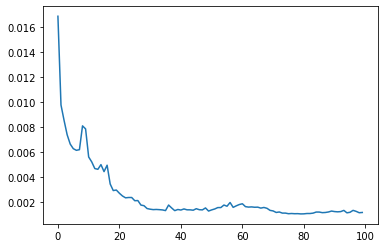

In [12]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=50
positive_correlation_stock_num=20
negative_correlation_sotck_num=20
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'StockChart/SAMPLE',
    'StockChart/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)


lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )

sess.run(tf.compat.v1.global_variables_initializer())
    
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)
    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 26)
making dataset progress : finished	
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
result =  Tensor("concat:0", shape=(None, 32, 256), dtype=float32)
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f4ac14e0350>
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Y_2 =  (None, 32, 64)
Ple

0.40331823437009007
0.3098613485926762
epoch : 12, t_cost : 0.003878, e_cost : 0.007042, elapsed time : 47.21sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.3999720577849075
0.45551125321071595
epoch : 13, t_cost : 0.003846, e_cost : 0.010353, elapsed time : 47.18sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.4153562370920554
0.8071166961453855
epoch : 14, t_cost : 0.003994, e_cost : 0.018344, elapsed time : 47.18sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.45692409528419375
0.6979881127481349
epoch : 15, t_cost : 0.004394, e_cost : 0.015863, elapsed time : 47.19sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326,

(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.34891104826238006
0.07298311390331946
epoch : 43, t_cost : 0.003355, e_cost : 0.001659, elapsed time : 47.37sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.3093969378969632
0.06385572103317827
epoch : 44, t_cost : 0.002975, e_cost : 0.001451, elapsed time : 47.28sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.28896405594423413
0.07561843428993598
epoch : 45, t_cost : 0.002779, e_cost : 0.001719, elapsed time : 47.32sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.27634506265167147
0.07194

(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.2188457889133133
0.08077136977226473
epoch : 73, t_cost : 0.002104, e_cost : 0.001836, elapsed time : 47.32sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.26560843107290566
0.05620806533261202
epoch : 74, t_cost : 0.002554, e_cost : 0.001277, elapsed time : 47.25sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.22796372853918
0.0858821413712576
epoch : 75, t_cost : 0.002192, e_cost : 0.001952, elapsed time : 47.30sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.2040244028903544
0.07060942059615627
epoch : 76, t_cost : 0.001962, e_cost : 0.001605, elapsed time : 47.24s

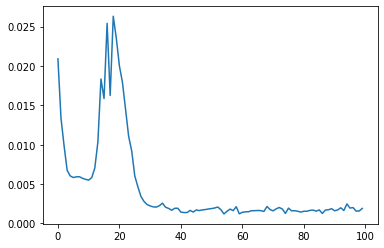

In [7]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=70
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'StockChart/SAMPLE',
    'StockChart/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)


lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )

sess.run(tf.compat.v1.global_variables_initializer())
    
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)
    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 26)
making dataset progress : finished	
result =  Tensor("concat:0", shape=(None, 32, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f4acc0e5410>
Y_2 =  (None, 32, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f4ba0113550>, <gast.gast.Return object at 0x7f4ba01135d0>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f4ba0113550>, <gast.gast.Return object at 0x7f4ba01135d0>]
inputs :  Tensor("rnn_32/transpose_1:0", shape=(None, 32, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 32), dtype=float32)
enco

(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.6107728347415105
0.15523606369970366
epoch : 22, t_cost : 0.005873, e_cost : 0.003528, elapsed time : 47.23sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.5149491637712345
0.12024804425891489
epoch : 23, t_cost : 0.004951, e_cost : 0.002733, elapsed time : 47.28sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.5260072263190523
0.13965627551078796
epoch : 24, t_cost : 0.005058, e_cost : 0.003174, elapsed time : 47.19sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.5225233639357612
0.14890146

(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.24154646549141034
0.05270774822565727
epoch : 52, t_cost : 0.002323, e_cost : 0.001198, elapsed time : 47.41sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.323795436124783
0.06074123634607531
epoch : 53, t_cost : 0.003113, e_cost : 0.001380, elapsed time : 47.24sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.3555039489874616
0.05825489011476748
epoch : 54, t_cost : 0.003418, e_cost : 0.001324, elapsed time : 47.27sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.4331758367479779
0.06323264085222036
epoch : 55, t_cost : 0.004165, e_cost : 0.001437, elapsed time : 47.2

0.19993485970189795
0.06393821342498995
epoch : 82, t_cost : 0.001922, e_cost : 0.001453, elapsed time : 47.25sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.1804218107718043
0.08426895353477448
epoch : 83, t_cost : 0.001735, e_cost : 0.001915, elapsed time : 47.27sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.16807353089097887
0.07405126845696941
epoch : 84, t_cost : 0.001616, e_cost : 0.001683, elapsed time : 47.24sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.1617528591887094
0.06584112124983221
epoch : 85, t_cost : 0.001555, e_cost : 0.001496, elapsed time : 47.21sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (533

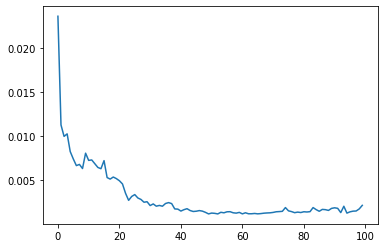

In [8]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=70
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'StockChart/SAMPLE',
    'StockChart/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)


lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )

sess.run(tf.compat.v1.global_variables_initializer())
    
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)
    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 26)
making dataset progress : finished	
result =  Tensor("concat:0", shape=(None, 32, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f4a71beab10>
Y_2 =  (None, 32, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f4aa87a2110>, <gast.gast.Return object at 0x7f4aa87a2190>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f4aa87a2110>, <gast.gast.Return object at 0x7f4aa87a2190>]
inputs :  Tensor("rnn_32/transpose_1:0", shape=(None, 32, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 32), dtype=float32)
enco

(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.6636646104743704
0.11846555629745126
epoch : 22, t_cost : 0.006381, e_cost : 0.002692, elapsed time : 47.48sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.8878302340162918
0.10980232118163258
epoch : 23, t_cost : 0.008537, e_cost : 0.002496, elapsed time : 47.46sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.9252214709995314
0.10332688316702843
epoch : 24, t_cost : 0.008896, e_cost : 0.002348, elapsed time : 47.51sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.9818029174348339
0.10328610

(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.2248252300778404
0.17109007539693266
epoch : 52, t_cost : 0.002162, e_cost : 0.003888, elapsed time : 47.44sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.2562982973176986
0.0658325238910038
epoch : 53, t_cost : 0.002464, e_cost : 0.001496, elapsed time : 47.55sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.24657008569920436
0.07733160271891393
epoch : 54, t_cost : 0.002371, e_cost : 0.001758, elapsed time : 47.46sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.28572787292068824
0.05359099738416262
epoch : 55, t_cost : 0.002747, e_cost : 0.001218, elapsed time : 47.

0.16797567799221724
0.053136794274905697
epoch : 82, t_cost : 0.001615, e_cost : 0.001208, elapsed time : 47.50sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.1739143182639964
0.05287641490576789
epoch : 83, t_cost : 0.001672, e_cost : 0.001202, elapsed time : 47.51sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.18001526407897472
0.05285814413218759
epoch : 84, t_cost : 0.001731, e_cost : 0.001201, elapsed time : 47.53sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.18016424687812105
0.052134727069642395
epoch : 85, t_cost : 0.001732, e_cost : 0.001185, elapsed time : 47.45sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (

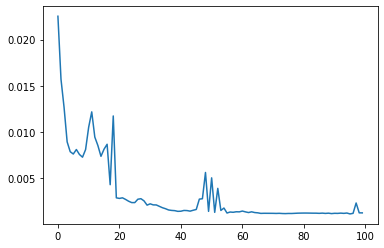

In [9]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=70
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'StockChart/SAMPLE',
    'StockChart/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)


lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )

sess.run(tf.compat.v1.global_variables_initializer())
    
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)
    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 26)
making dataset progress : finished	
result =  Tensor("concat:0", shape=(None, 32, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f4ac1452ad0>
Y_2 =  (None, 32, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f4b40530350>, <gast.gast.Return object at 0x7f4b405303d0>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f4b40530350>, <gast.gast.Return object at 0x7f4b405303d0>]
inputs :  Tensor("rnn_32/transpose_1:0", shape=(None, 32, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 32), dtype=float32)
enco

(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.6041750384029001
0.15132688969606534
epoch : 22, t_cost : 0.005809, e_cost : 0.003439, elapsed time : 47.48sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.6319113299250603
0.13429306412581354
epoch : 23, t_cost : 0.006076, e_cost : 0.003052, elapsed time : 47.48sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.556818944751285
0.1178361265338026
epoch : 24, t_cost : 0.005354, e_cost : 0.002678, elapsed time : 47.49sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.5023470482556149
0.1089126067

(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.3386453918647021
0.05573265498969704
epoch : 52, t_cost : 0.003256, e_cost : 0.001267, elapsed time : 47.85sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.3503016517497599
0.0548190965782851
epoch : 53, t_cost : 0.003368, e_cost : 0.001246, elapsed time : 48.35sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.33747361128916964
0.056000575015787035
epoch : 54, t_cost : 0.003245, e_cost : 0.001273, elapsed time : 47.87sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.32081721699796617
0.05389453787938692
epoch : 55, t_cost : 0.003085, e_cost : 0.001225, elapsed time : 47

0.21348757826490328
0.047106727317441255
epoch : 82, t_cost : 0.002053, e_cost : 0.001071, elapsed time : 47.45sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.24434499558992684
0.047620329016353935
epoch : 83, t_cost : 0.002349, e_cost : 0.001082, elapsed time : 47.43sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.24065516790142283
0.04988413397222757
epoch : 84, t_cost : 0.002314, e_cost : 0.001134, elapsed time : 47.51sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
0.22266088746255264
0.04857326581259258
epoch : 85, t_cost : 0.002141, e_cost : 0.001104, elapsed time : 47.48sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) 

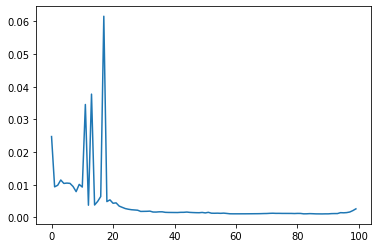

In [10]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=70
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'StockChart/SAMPLE',
    'StockChart/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)


lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )

sess.run(tf.compat.v1.global_variables_initializer())
    
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)
    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

In [11]:
class StockData():
    """
        훈련용 데이터세트와 평가용 데이터세트를 만들기 위한 과정.

        파라미터:
            folderPath : 종목시장의 주가 csv가 저장되어있는 디렉토리 경로.
            indexPath : 종목시장의 인덱스 주 csv파일의 경로.
            timewindowsize : LSTM의 입력으로 들어가는 타임의 사이즈. 10일 경우 미래주가를 예측하기 위해 이전 10일 주가를 사용.
            windowsizeForPCC : PCC를 계산하기 위해 사용되는 타임의 사이즈. 10일 경우 관계주를 구하기 위해 이전 10일 주가를 사용.
            PositiveStockNumber : 긍정관계주 개수.
            NegativeStockNumber : 부정관계주 개수.
            train_test_rate : 훈련:평가 세트 비율. 0.7일 경우 생성된 데이터 세트중 70%는 훈련용, 30%는 평가용으로 사용.
            batchSize : 세트를 나누는 배치 사이즈.

        과정:
            종목시장의 모든 종목의 시가와 인덱스 시가를 읽어옴.
            minmax스케일러를 각 종목과 인덱스에 적용하고 저장.
            PCC계산, 관계주 계산.
            데이터세트 저장.
               
    """
    def __init__(self,folderPath,indexPath,timewindowsize,windowsizeForPCC,PostiveStockNumber,NegativeStockNumber,train_test_rate,batchSize):        
               
        if(train_test_rate<=0 or train_test_rate>=1):
            raise ValueError('train_test_rate should be between 0 and 1')        
        self.P=PostiveStockNumber
        self.N=NegativeStockNumber        
        self.T=timewindowsize
        self.Tr=windowsizeForPCC
        self.folderPath = folderPath      
        self.indexPath=indexPath    
        self.batchSize=batchSize
        self.date_duration=3000
        
        self.train_test_rate=train_test_rate
        self.scaler=MinMaxScaler(feature_range=(-1,1))  
        self.indexScaler = MinMaxScaler(feature_range=(-1,1))

        self.indexPrice = self.loadIndex()
        self.stockPrice = self.loadCSV()

        self.trainSet,self.testSet=self.make_dataset()

        self.batchNum={}
    
    def getBatch(self,option):
        """
        클래스에 저장된 세트를 y,xp,xn,xi,target으로 나누고 batch생성.

        args:
            option='training' or 'evaluation'

        returns:
            batch 제너레이터
            batch={'y','xp','xn','xi','target'}
        """
        if(option is not 'training' and option is not 'evaluation'):
            raise ValueError('option should be "training" or "evaluation".')

        if(option is 'training'):
            returnSet = self.trainSet
        else:
            returnSet = self.testSet
        
        y=[]
        xp=[]
        xn=[]
        xi=[]
        target=[]

        for d in returnSet:
            y.append(d['target_history'])  
            xp.append(d['pos_history'])       
            xn.append(d['neg_history'])       
            xi.append(d['index_history'])       
            target.append(d['target_price'])             
        y=np.reshape(y,(-1,self.T,1))
        xp=np.reshape(xp,(-1,10,self.T,1))
        xn=np.reshape(xn,(-1,10,self.T,1))
        xi=np.reshape(xi,(-1,self.T,1))
        target=np.reshape(target,(-1,1))

        print(y.shape,xp.shape,xn.shape,xi.shape,target.shape)     

        batchNum=int(len(y)/self.batchSize)
        self.batchNum[option]=batchNum

        for i in range(batchNum):
            yield {'y':y[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xp':xp[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xn':xn[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xi':xi[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'target':target[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32)}

    def loadCSV(self):
        """
        csv파일이 있는 폴더를 입력으로 받아 데이터를 읽어옴.
        """
        csvList=os.listdir(self.folderPath)        
        dataframe = pd.DataFrame([])
        

        for csv in csvList:
            data=pd.read_csv(self.folderPath+'/'+csv,engine='python')
            if(len(data)>self.date_duration):
                data=data[-self.date_duration-1:-1]
                data=data.reset_index()
                data=data['open']

                dataframe=dataframe.append(data,ignore_index=True)
        dataT=np.array(dataframe).T
        self.scaler.fit(dataT)
        dataT=self.scaler.transform(dataT)
        dataT=dataT.T
        dataframe=pd.DataFrame(dataT)
        dataframe=dataframe.transpose()
        print('StockPrice shape: ',dataframe.shape)
        return dataframe
    
    def loadIndex(self):
        data=pd.read_csv(self.indexPath,engine='python')
        data=data[-self.date_duration-1:-1]        
        data=data.reset_index()
        data=data.fillna(method='ffill')

        data=np.array(data['Open'])
        data=np.reshape(data,(-1,1))

        data=self.indexScaler.fit_transform(data)

        data=pd.DataFrame(np.squeeze(data))        

        print('IndexPrice shape: ',data.shape)
        return data 


    def make_dataset(self):
        """
        예측모델에 사용되는 입력,타겟 데이터세트.
        입력데이터의 shape는 (목표주식+관계주식+인덱스, 타임윈도우사이즈)
        타겟데이터의 shape는 (1,1)
        """
        maxday=max([self.T,self.Tr])
        dataset=[]

        for i in range(maxday,len(self.stockPrice)):
            print('making dataset progress : {}/{}'.format(i,len(self.stockPrice)),end='\r')
            priceSet=self.stockPrice.loc[i-self.T:i-1]
            targetSet=self.stockPrice.loc[i]
            positiveSet,negativeSet=self.calculate_correlation(self.stockPrice.loc[i-maxday:i-1])
            indexSet = self.indexPrice.loc[i-self.T:i-1]

            for targetNum in priceSet.columns:
                target_history=np.reshape(np.array(priceSet[targetNum]),(self.T,1))
                pos_history=np.reshape(np.array(positiveSet[targetNum].T),(10,self.T,1))
                neg_history=np.reshape(np.array(negativeSet[targetNum].T),(10,self.T,1))
                index_history=np.reshape(np.array(indexSet),(self.T,1))
                target_price=np.reshape(np.array(targetSet[targetNum]),(1,1))

                dataset.append({'target_history':target_history,
                                'pos_history':pos_history,
                                'neg_history':neg_history,
                                'index_history':index_history,
                                'target_price':target_price
                            })
        print('making dataset progress : finished\t')
        
        return dataset[:int(len(dataset)*self.train_test_rate)],dataset[int(len(dataset)*self.train_test_rate):]

    def calculate_correlation(self,priceSet):
        """
        Pearson Correlation Coefficient(PCC)를 계산하고,
        높은순으로 긍정관계주, 낮은순으로 부정관계주를 설정한 개수만큼 생성하여 리스트에 저장한후, 리턴.
        입력은 전체 종목의 타임윈도우간의 주가.

        Returns:
            #모든종목의 관계주. 
            긍정관계주 shape = (종목 수, dataframe(T*P))
            부정관계주 shape = (종목 수, dataframe(T*N))
        """    
        positive=[]
        negative=[] 
        corr=priceSet[-self.Tr:].corr(method='pearson')

        for i in corr.columns:
            tempCorr=corr[i].sort_values(ascending=False)
            index_P=tempCorr[1:self.P+1].index
            index_N=tempCorr[-self.N:].index
            
            priceSet=priceSet[-self.T:]
            posSet=priceSet[index_P]
            negSet=priceSet[index_N]
            posSet.columns=range(self.P)
            negSet.columns=range(self.N)
            
            positive.append(posSet)
            negative.append(negSet)
        return positive,negative

            
"""testLine
kospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)
print(np.shape(kospi.trainSet))
print(np.shape(kospi.testSet))
"""


"testLine\nkospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)\nprint(np.shape(kospi.trainSet))\nprint(np.shape(kospi.testSet))\n"

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 26)
making dataset progress : finished	
result =  Tensor("concat:0", shape=(None, 64, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f4b406ff3d0>
Y_2 =  (None, 64, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f4acc0ea890>, <gast.gast.Return object at 0x7f4acc0ea910>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f4acc0ea890>, <gast.gast.Return object at 0x7f4acc0ea910>]
inputs :  Tensor("rnn_22/transpose_1:0", shape=(None, 64, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 64), dtype=float32)
enco

(52780, 64, 1) (52780, 10, 64, 1) (52780, 10, 64, 1) (52780, 64, 1) (52780, 1)
(22620, 64, 1) (22620, 10, 64, 1) (22620, 10, 64, 1) (22620, 64, 1) (22620, 1)
0.3136464696144685
0.07796663121553138
epoch : 22, t_cost : 0.003045, e_cost : 0.001772, elapsed time : 86.60sec
(52780, 64, 1) (52780, 10, 64, 1) (52780, 10, 64, 1) (52780, 64, 1) (52780, 1)
(22620, 64, 1) (22620, 10, 64, 1) (22620, 10, 64, 1) (22620, 64, 1) (22620, 1)
0.30334868119098246
0.07959582930197939
epoch : 23, t_cost : 0.002945, e_cost : 0.001809, elapsed time : 86.55sec
(52780, 64, 1) (52780, 10, 64, 1) (52780, 10, 64, 1) (52780, 64, 1) (52780, 1)
(22620, 64, 1) (22620, 10, 64, 1) (22620, 10, 64, 1) (22620, 64, 1) (22620, 1)
0.29125972487963736
0.08194930118042976
epoch : 24, t_cost : 0.002828, e_cost : 0.001862, elapsed time : 86.54sec
(52780, 64, 1) (52780, 10, 64, 1) (52780, 10, 64, 1) (52780, 64, 1) (52780, 1)
(22620, 64, 1) (22620, 10, 64, 1) (22620, 10, 64, 1) (22620, 64, 1) (22620, 1)
0.28514230670407414
0.08261

(22620, 64, 1) (22620, 10, 64, 1) (22620, 10, 64, 1) (22620, 64, 1) (22620, 1)
0.17158409880357794
0.04996281024068594
epoch : 52, t_cost : 0.001666, e_cost : 0.001136, elapsed time : 86.49sec
(52780, 64, 1) (52780, 10, 64, 1) (52780, 10, 64, 1) (52780, 64, 1) (52780, 1)
(22620, 64, 1) (22620, 10, 64, 1) (22620, 10, 64, 1) (22620, 64, 1) (22620, 1)
0.16032275033649057
0.04799997521331534
epoch : 53, t_cost : 0.001557, e_cost : 0.001091, elapsed time : 86.58sec
(52780, 64, 1) (52780, 10, 64, 1) (52780, 10, 64, 1) (52780, 64, 1) (52780, 1)
(22620, 64, 1) (22620, 10, 64, 1) (22620, 10, 64, 1) (22620, 64, 1) (22620, 1)
0.13906539336312562
0.047776544524822384
epoch : 54, t_cost : 0.001350, e_cost : 0.001086, elapsed time : 86.52sec
(52780, 64, 1) (52780, 10, 64, 1) (52780, 10, 64, 1) (52780, 64, 1) (52780, 1)
(22620, 64, 1) (22620, 10, 64, 1) (22620, 10, 64, 1) (22620, 64, 1) (22620, 1)
0.1377143308345694
0.048582669405732304
epoch : 55, t_cost : 0.001337, e_cost : 0.001104, elapsed time :

0.19474180444376543
0.05152777541661635
epoch : 82, t_cost : 0.001891, e_cost : 0.001171, elapsed time : 87.37sec
(52780, 64, 1) (52780, 10, 64, 1) (52780, 10, 64, 1) (52780, 64, 1) (52780, 1)
(22620, 64, 1) (22620, 10, 64, 1) (22620, 10, 64, 1) (22620, 64, 1) (22620, 1)
0.19745027925819159
0.05836702583474107
epoch : 83, t_cost : 0.001917, e_cost : 0.001327, elapsed time : 86.65sec
(52780, 64, 1) (52780, 10, 64, 1) (52780, 10, 64, 1) (52780, 64, 1) (52780, 1)
(22620, 64, 1) (22620, 10, 64, 1) (22620, 10, 64, 1) (22620, 64, 1) (22620, 1)
0.19746919005410746
0.05081132263876498
epoch : 84, t_cost : 0.001917, e_cost : 0.001155, elapsed time : 86.47sec
(52780, 64, 1) (52780, 10, 64, 1) (52780, 10, 64, 1) (52780, 64, 1) (52780, 1)
(22620, 64, 1) (22620, 10, 64, 1) (22620, 10, 64, 1) (22620, 64, 1) (22620, 1)
0.1426184672745876
0.04791661104536615
epoch : 85, t_cost : 0.001385, e_cost : 0.001089, elapsed time : 86.52sec
(52780, 64, 1) (52780, 10, 64, 1) (52780, 10, 64, 1) (52780, 64, 1) (52

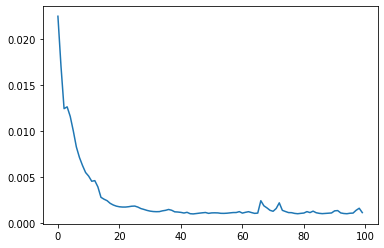

In [12]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=64
timesize_for_calc_correlation=100
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'StockChart/SAMPLE',
    'StockChart/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)


lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )

sess.run(tf.compat.v1.global_variables_initializer())
    
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)
    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

In [ ]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=64
timesize_for_calc_correlation=100
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'StockChart/SAMPLE',
    'StockChart/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)


lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )

sess.run(tf.compat.v1.global_variables_initializer())
    
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)
    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 26)
making dataset progress : finished	
result =  Tensor("concat:0", shape=(None, 64, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f4aa80c0b90>
Y_2 =  (None, 64, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f4a715f16d0>, <gast.gast.Return object at 0x7f4a715f1750>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f4a715f16d0>, <gast.gast.Return object at 0x7f4a715f1750>]
inputs :  Tensor("rnn_22/transpose_1:0", shape=(None, 64, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 64), dtype=float32)
enco

(52780, 64, 1) (52780, 10, 64, 1) (52780, 10, 64, 1) (52780, 64, 1) (52780, 1)
(22620, 64, 1) (22620, 10, 64, 1) (22620, 10, 64, 1) (22620, 64, 1) (22620, 1)
0.3371750738588162
0.09221564931795001
epoch : 22, t_cost : 0.003274, e_cost : 0.002096, elapsed time : 86.47sec
(52780, 64, 1) (52780, 10, 64, 1) (52780, 10, 64, 1) (52780, 64, 1) (52780, 1)
(22620, 64, 1) (22620, 10, 64, 1) (22620, 10, 64, 1) (22620, 64, 1) (22620, 1)
0.4848938944051042
0.07892022177111357
epoch : 23, t_cost : 0.004708, e_cost : 0.001794, elapsed time : 86.36sec
(52780, 64, 1) (52780, 10, 64, 1) (52780, 10, 64, 1) (52780, 64, 1) (52780, 1)
(22620, 64, 1) (22620, 10, 64, 1) (22620, 10, 64, 1) (22620, 64, 1) (22620, 1)
0.3433739168685861
0.06886978208785877
epoch : 24, t_cost : 0.003334, e_cost : 0.001565, elapsed time : 86.44sec
(52780, 64, 1) (52780, 10, 64, 1) (52780, 10, 64, 1) (52780, 64, 1) (52780, 1)
(22620, 64, 1) (22620, 10, 64, 1) (22620, 10, 64, 1) (22620, 64, 1) (22620, 1)
0.33755178248975426
0.0694786

In [ ]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=64
timesize_for_calc_correlation=100
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'StockChart/SAMPLE',
    'StockChart/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)


lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )

sess.run(tf.compat.v1.global_variables_initializer())
    
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)
    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

In [ ]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=64
timesize_for_calc_correlation=100
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'StockChart/SAMPLE',
    'StockChart/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)


lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )

sess.run(tf.compat.v1.global_variables_initializer())
    
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)
    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

In [7]:
class StockData():
    """
        훈련용 데이터세트와 평가용 데이터세트를 만들기 위한 과정.

        파라미터:
            folderPath : 종목시장의 주가 csv가 저장되어있는 디렉토리 경로.
            indexPath : 종목시장의 인덱스 주 csv파일의 경로.
            timewindowsize : LSTM의 입력으로 들어가는 타임의 사이즈. 10일 경우 미래주가를 예측하기 위해 이전 10일 주가를 사용.
            windowsizeForPCC : PCC를 계산하기 위해 사용되는 타임의 사이즈. 10일 경우 관계주를 구하기 위해 이전 10일 주가를 사용.
            PositiveStockNumber : 긍정관계주 개수.
            NegativeStockNumber : 부정관계주 개수.
            train_test_rate : 훈련:평가 세트 비율. 0.7일 경우 생성된 데이터 세트중 70%는 훈련용, 30%는 평가용으로 사용.
            batchSize : 세트를 나누는 배치 사이즈.

        과정:
            종목시장의 모든 종목의 시가와 인덱스 시가를 읽어옴.
            minmax스케일러를 각 종목과 인덱스에 적용하고 저장.
            PCC계산, 관계주 계산.
            데이터세트 저장.
               
    """
    def __init__(self,folderPath,indexPath,timewindowsize,windowsizeForPCC,PostiveStockNumber,NegativeStockNumber,train_test_rate,batchSize):        
               
        if(train_test_rate<=0 or train_test_rate>=1):
            raise ValueError('train_test_rate should be between 0 and 1')        
        self.P=PostiveStockNumber
        self.N=NegativeStockNumber        
        self.T=timewindowsize
        self.Tr=windowsizeForPCC
        self.folderPath = folderPath      
        self.indexPath=indexPath    
        self.batchSize=batchSize
        self.date_duration=3000
        
        self.train_test_rate=train_test_rate
        self.scaler=MinMaxScaler(feature_range=(-1,1))  
        self.indexScaler = MinMaxScaler(feature_range=(-1,1))

        self.indexPrice = self.loadIndex()
        self.stockPrice = self.loadCSV()

        self.trainSet,self.testSet=self.make_dataset()

        self.batchNum={}
    
    def getBatch(self,option):
        """
        클래스에 저장된 세트를 y,xp,xn,xi,target으로 나누고 batch생성.

        args:
            option='training' or 'evaluation'

        returns:
            batch 제너레이터
            batch={'y','xp','xn','xi','target'}
        """
        if(option is not 'training' and option is not 'evaluation'):
            raise ValueError('option should be "training" or "evaluation".')

        if(option is 'training'):
            returnSet = self.trainSet
        else:
            returnSet = self.testSet
        
        y=[]
        xp=[]
        xn=[]
        xi=[]
        target=[]

        for d in returnSet:
            y.append(d['target_history'])  
            xp.append(d['pos_history'])       
            xn.append(d['neg_history'])       
            xi.append(d['index_history'])       
            target.append(d['target_price'])             
        y=np.reshape(y,(-1,self.T,1))
        xp=np.reshape(xp,(-1,15,self.T,1))
        xn=np.reshape(xn,(-1,15,self.T,1))
        xi=np.reshape(xi,(-1,self.T,1))
        target=np.reshape(target,(-1,1))

        print(y.shape,xp.shape,xn.shape,xi.shape,target.shape)     

        batchNum=int(len(y)/self.batchSize)
        self.batchNum[option]=batchNum

        for i in range(batchNum):
            yield {'y':y[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xp':xp[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xn':xn[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xi':xi[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'target':target[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32)}

    def loadCSV(self):
        """
        csv파일이 있는 폴더를 입력으로 받아 데이터를 읽어옴.
        """
        csvList=os.listdir(self.folderPath)        
        dataframe = pd.DataFrame([])
        

        for csv in csvList:
            data=pd.read_csv(self.folderPath+'/'+csv,engine='python')
            if(len(data)>self.date_duration):
                data=data[-self.date_duration-1:-1]
                data=data.reset_index()
                data=data['open']

                dataframe=dataframe.append(data,ignore_index=True)
        dataT=np.array(dataframe).T
        self.scaler.fit(dataT)
        dataT=self.scaler.transform(dataT)
        dataT=dataT.T
        dataframe=pd.DataFrame(dataT)
        dataframe=dataframe.transpose()
        print('StockPrice shape: ',dataframe.shape)
        return dataframe
    
    def loadIndex(self):
        data=pd.read_csv(self.indexPath,engine='python')
        data=data[-self.date_duration-1:-1]        
        data=data.reset_index()
        data=data.fillna(method='ffill')

        data=np.array(data['Open'])
        data=np.reshape(data,(-1,1))

        data=self.indexScaler.fit_transform(data)

        data=pd.DataFrame(np.squeeze(data))        

        print('IndexPrice shape: ',data.shape)
        return data 


    def make_dataset(self):
        """
        예측모델에 사용되는 입력,타겟 데이터세트.
        입력데이터의 shape는 (목표주식+관계주식+인덱스, 타임윈도우사이즈)
        타겟데이터의 shape는 (1,1)
        """
        maxday=max([self.T,self.Tr])
        dataset=[]

        for i in range(maxday,len(self.stockPrice)):
            print('making dataset progress : {}/{}'.format(i,len(self.stockPrice)),end='\r')
            priceSet=self.stockPrice.loc[i-self.T:i-1]
            targetSet=self.stockPrice.loc[i]
            positiveSet,negativeSet=self.calculate_correlation(self.stockPrice.loc[i-maxday:i-1])
            indexSet = self.indexPrice.loc[i-self.T:i-1]

            for targetNum in priceSet.columns:
                target_history=np.reshape(np.array(priceSet[targetNum]),(self.T,1))
                pos_history=np.reshape(np.array(positiveSet[targetNum].T),(15,self.T,1))
                neg_history=np.reshape(np.array(negativeSet[targetNum].T),(15,self.T,1))
                index_history=np.reshape(np.array(indexSet),(self.T,1))
                target_price=np.reshape(np.array(targetSet[targetNum]),(1,1))

                dataset.append({'target_history':target_history,
                                'pos_history':pos_history,
                                'neg_history':neg_history,
                                'index_history':index_history,
                                'target_price':target_price
                            })
        print('making dataset progress : finished\t')
        
        return dataset[:int(len(dataset)*self.train_test_rate)],dataset[int(len(dataset)*self.train_test_rate):]

    def calculate_correlation(self,priceSet):
        """
        Pearson Correlation Coefficient(PCC)를 계산하고,
        높은순으로 긍정관계주, 낮은순으로 부정관계주를 설정한 개수만큼 생성하여 리스트에 저장한후, 리턴.
        입력은 전체 종목의 타임윈도우간의 주가.

        Returns:
            #모든종목의 관계주. 
            긍정관계주 shape = (종목 수, dataframe(T*P))
            부정관계주 shape = (종목 수, dataframe(T*N))
        """    
        positive=[]
        negative=[] 
        corr=priceSet[-self.Tr:].corr(method='pearson')

        for i in corr.columns:
            tempCorr=corr[i].sort_values(ascending=False)
            index_P=tempCorr[1:self.P+1].index
            index_N=tempCorr[-self.N:].index
            
            priceSet=priceSet[-self.T:]
            posSet=priceSet[index_P]
            negSet=priceSet[index_N]
            posSet.columns=range(self.P)
            negSet.columns=range(self.N)
            
            positive.append(posSet)
            negative.append(negSet)
        return positive,negative

            
"""testLine
kospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)
print(np.shape(kospi.trainSet))
print(np.shape(kospi.testSet))
"""


"testLine\nkospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)\nprint(np.shape(kospi.trainSet))\nprint(np.shape(kospi.testSet))\n"

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 26)
making dataset progress : finished	
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
result =  Tensor("concat:0", shape=(None, 32, 256), dtype=float32)
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f08ff2b7950>
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Y_2 =  (None, 32, 64)
inp

(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
40.3457650244236
14.796100854873657
epoch : 19, t_cost : 0.387940, e_cost : 0.336275, elapsed time : 110.62sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
40.15925592184067
14.745269536972046
epoch : 20, t_cost : 0.386147, e_cost : 0.335120, elapsed time : 110.00sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
39.968512773513794
14.663801193237305
epoch : 21, t_cost : 0.384313, e_cost : 0.333268, elapsed time : 110.02sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
39.74743410944939
14.598961859941483
epoch : 22, t_cost : 0.382187, e_cost : 0.331795, elapsed time : 110.76sec

(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
34.3081826120615
12.995117396116257
epoch : 50, t_cost : 0.329886, e_cost : 0.295344, elapsed time : 109.03sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
34.10840862989426
12.948934897780418
epoch : 51, t_cost : 0.327965, e_cost : 0.294294, elapsed time : 109.92sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
33.87544646859169
12.881669461727142
epoch : 52, t_cost : 0.325725, e_cost : 0.292765, elapsed time : 110.14sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
33.71150557696819
12.817139521241

28.667902812361717
11.467629134654999
epoch : 80, t_cost : 0.275653, e_cost : 0.260628, elapsed time : 108.78sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
28.48747457563877
11.446068450808525
epoch : 81, t_cost : 0.273918, e_cost : 0.260138, elapsed time : 108.52sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
28.32219722867012
11.387411803007126
epoch : 82, t_cost : 0.272329, e_cost : 0.258805, elapsed time : 109.00sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)
(22854, 32, 1) (22854, 15, 32, 1) (22854, 15, 32, 1) (22854, 32, 1) (22854, 1)
28.1608464717865
11.361341923475266
epoch : 83, t_cost : 0.270777, e_cost : 0.258212, elapsed time : 108.45sec
(53326, 32, 1) (53326, 15, 32, 1) (53326, 15, 32, 1) (53326, 32, 1) (53326, 1)

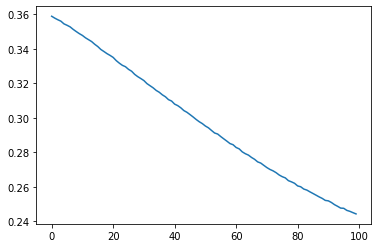

In [9]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=70
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'data/kospi/SAMPLE',
    'data/kospi/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)


lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )

sess.run(tf.compat.v1.global_variables_initializer())
    
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)
    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 26)
making dataset progress : finished	
result =  Tensor("concat:0", shape=(None, 16, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f090e02a590>
Y_2 =  (None, 16, 64)
inputs :  Tensor("rnn_32/transpose_1:0", shape=(None, 16, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 16), dtype=float32)
encoder_states :  Tensor("encoder/transpose_1:0", shape=(None, 16, 64), dtype=float32)
y_pred :  Tensor("decoder/dense_4/BiasAdd:0", shape=(None, 1), dtype=float32)
(53326, 16, 1) (53326, 15, 16, 1) (53326, 15, 16, 1) (53326, 16, 1) (53326, 1)
(22854, 16, 1) (22854, 15, 16, 1) (22854, 15, 16, 1) (22854, 16, 1) (22854, 1)
44.244477689266205
16.025712311267853
epoch : 0, t_cost : 0.425428, e_cost : 0.364221, elapsed time : 55.28sec
(53326, 16, 1) (53326, 15, 16, 1) (53326, 15, 16, 1) (53326, 16, 1) (53326, 1)
(22854, 16, 1) (22854, 15, 16, 1) (22854, 15, 16, 1) (22854, 16, 1) (22854, 1)
44.10843345522

39.22558316588402
14.475330829620361
epoch : 28, t_cost : 0.377169, e_cost : 0.328985, elapsed time : 46.22sec
(53326, 16, 1) (53326, 15, 16, 1) (53326, 15, 16, 1) (53326, 16, 1) (53326, 1)
(22854, 16, 1) (22854, 15, 16, 1) (22854, 15, 16, 1) (22854, 16, 1) (22854, 1)
38.97816249728203
14.384003043174744
epoch : 29, t_cost : 0.374790, e_cost : 0.326909, elapsed time : 46.52sec
(53326, 16, 1) (53326, 15, 16, 1) (53326, 15, 16, 1) (53326, 16, 1) (53326, 1)
(22854, 16, 1) (22854, 15, 16, 1) (22854, 15, 16, 1) (22854, 16, 1) (22854, 1)
38.782706052064896
14.334090143442154
epoch : 30, t_cost : 0.372911, e_cost : 0.325775, elapsed time : 46.56sec
(53326, 16, 1) (53326, 15, 16, 1) (53326, 15, 16, 1) (53326, 16, 1) (53326, 1)
(22854, 16, 1) (22854, 15, 16, 1) (22854, 15, 16, 1) (22854, 16, 1) (22854, 1)
38.57662409543991
14.27198812365532
epoch : 31, t_cost : 0.370929, e_cost : 0.324363, elapsed time : 46.34sec
(53326, 16, 1) (53326, 15, 16, 1) (53326, 15, 16, 1) (53326, 16, 1) (53326, 1)
(22

(22854, 16, 1) (22854, 15, 16, 1) (22854, 15, 16, 1) (22854, 16, 1) (22854, 1)
32.565476804971695
12.532140791416168
epoch : 59, t_cost : 0.313130, e_cost : 0.284821, elapsed time : 46.64sec
(53326, 16, 1) (53326, 15, 16, 1) (53326, 15, 16, 1) (53326, 16, 1) (53326, 1)
(22854, 16, 1) (22854, 15, 16, 1) (22854, 15, 16, 1) (22854, 16, 1) (22854, 1)
32.35180941224098
12.472582712769508
epoch : 60, t_cost : 0.311075, e_cost : 0.283468, elapsed time : 46.65sec
(53326, 16, 1) (53326, 15, 16, 1) (53326, 15, 16, 1) (53326, 16, 1) (53326, 1)
(22854, 16, 1) (22854, 15, 16, 1) (22854, 15, 16, 1) (22854, 16, 1) (22854, 1)
32.14563758671284
12.390790164470673
epoch : 61, t_cost : 0.309093, e_cost : 0.281609, elapsed time : 46.76sec
(53326, 16, 1) (53326, 15, 16, 1) (53326, 15, 16, 1) (53326, 16, 1) (53326, 1)
(22854, 16, 1) (22854, 15, 16, 1) (22854, 15, 16, 1) (22854, 16, 1) (22854, 1)
31.895764768123627
12.327883914113045
epoch : 62, t_cost : 0.306690, e_cost : 0.280179, elapsed time : 46.60sec
(

(22854, 16, 1) (22854, 15, 16, 1) (22854, 15, 16, 1) (22854, 16, 1) (22854, 1)
26.49097114801407
10.975374683737755
epoch : 90, t_cost : 0.254721, e_cost : 0.249440, elapsed time : 44.85sec
(53326, 16, 1) (53326, 15, 16, 1) (53326, 15, 16, 1) (53326, 16, 1) (53326, 1)
(22854, 16, 1) (22854, 15, 16, 1) (22854, 15, 16, 1) (22854, 16, 1) (22854, 1)
26.331570729613304
10.93124283850193
epoch : 91, t_cost : 0.253188, e_cost : 0.248437, elapsed time : 45.24sec
(53326, 16, 1) (53326, 15, 16, 1) (53326, 15, 16, 1) (53326, 16, 1) (53326, 1)
(22854, 16, 1) (22854, 15, 16, 1) (22854, 15, 16, 1) (22854, 16, 1) (22854, 1)
26.160062611103058
10.899559557437897
epoch : 92, t_cost : 0.251539, e_cost : 0.247717, elapsed time : 44.79sec
(53326, 16, 1) (53326, 15, 16, 1) (53326, 15, 16, 1) (53326, 16, 1) (53326, 1)
(22854, 16, 1) (22854, 15, 16, 1) (22854, 15, 16, 1) (22854, 16, 1) (22854, 1)
26.01218755543232
10.875241875648499
epoch : 93, t_cost : 0.250117, e_cost : 0.247165, elapsed time : 44.83sec
(5

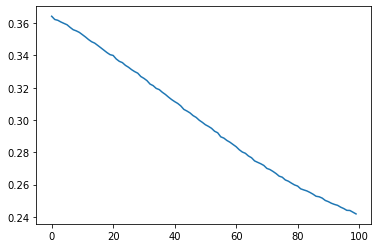

In [10]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=70
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'data/kospi/SAMPLE',
    'data/kospi/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)


lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )

sess.run(tf.compat.v1.global_variables_initializer())
    
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)
    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

In [11]:
class Model():
    """
    모든 예측모델들의 기본 클래스
    """
    def __init__(self,sess,name,windowsize,Pos,Neg):
        self.sess=sess
        self.name=name
        self.T=windowsize
        self.P=Pos
        self.N=Neg

        
        self._build_net()

    def _build_net(self):
        pass

class LSTM_Model(Model):
    """
    Basic LSTM list for test.
    """
    def _build_net(self):
       
        #tf. compat.v1.reset_default_graph()
        self.Y=tf.compat.v1.placeholder(tf.float32,[None,self.T,1])
        self.Xp=tf.compat.v1.placeholder(tf.float32,[None,self.P,self.T,1])
        self.Xn=tf.compat.v1.placeholder(tf.float32,[None,self.N,self.T,1])
        self.Xi=tf.compat.v1.placeholder(tf.float32,[None,self.T,1])
        self.Target=tf.compat.v1.placeholder(tf.float32,[None,1])


        Xps=tf.split(self.Xp,self.P,1)
        Xns=tf.split(self.Xn,self.N,1)
        Xp_list=[]
        Xn_list=[]

    
        LSTM=tf.compat.v1.nn.rnn_cell.LSTMCell(64,name='lstm1')
        
        Y_1,_=tf.compat.v1.nn.dynamic_rnn(LSTM,self.Y,dtype=tf.float32)
        Xi_1,_=tf.compat.v1.nn.dynamic_rnn(LSTM,self.Xi,dtype=tf.float32)
        for i in range(len(Xps)):
            o,_=tf.compat.v1.nn.dynamic_rnn(LSTM,tf.squeeze(Xps[i],axis=1),dtype=tf.float32)
            Xp_list.append(o)
        for i in range(len(Xns)):
            o,_=tf.compat.v1.nn.dynamic_rnn(LSTM,tf.squeeze(Xns[i],axis=1),dtype=tf.float32)
            Xn_list.append(o)
        Xp_1=tf.reduce_mean(Xp_list,0)
        Xn_1=tf.reduce_mean(Xn_list,0)

        result=tf.concat([Y_1,Xp_1,Xn_1,Xi_1],axis=2)
        print("result = " , result)

        #MI-LSTM
        LSTM2=MI_LSTMCell(64,4,name='lstm2')
        print("LSTM2 = " , LSTM2)
        Y_2,_ =tf.compat.v1.nn.dynamic_rnn(LSTM2,result,dtype=tf.float32)
        print("Y_2 = " , Y_2.shape)

        #Attention_Layer
        
        
        model = DARNN(64, 64, 64, self.T) 
        y_pred = model(Y_2, self.Y) 
        print("y_pred : " , y_pred )
        #y_pred = tf.squeeze(y_pred)
        #print("y_pred : " , y_pred )

        #Non-linear units for producing final prediction.
       

        self.out=y_pred
        #self.out=Y_2
        
        self.cost=tf.compat.v1.losses.mean_squared_error(labels=self.Target,predictions=self.out)
        self.optimizer=tf.compat.v1.train.AdagradDAOptimizer(0.001).minimize(self.cost)

    def outputs(self,y,xp,xn,xi,target):
        fd={self.Y:y,self.Xp:xp,self.Xn:xn,self.Xi:xi,self.Target:target}
        return self.sess.run(self.out,feed_dict=fd)
    


    def training(self,y,xp,xn,xi,target):
        fd={self.Y:y,self.Xp:xp,self.Xn:xn,self.Xi:xi,self.Target:target}
        return self.sess.run([self.cost,self.optimizer],feed_dict=fd)

    def returnCost(self,y,xp,xn,xi,target):
        fd={self.Y:y,self.Xp:xp,self.Xn:xn,self.Xi:xi,self.Target:target}
        return self.sess.run(self.cost,feed_dict=fd)
        

In [12]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=70
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'data/kospi/SAMPLE',
    'data/kospi/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)


lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )

sess.run(tf.compat.v1.global_variables_initializer())
    
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)
    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 26)
making dataset progress : finished	
result =  Tensor("concat:0", shape=(None, 32, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f08f3001b10>
Y_2 =  (None, 32, 64)
inputs :  Tensor("rnn_32/transpose_1:0", shape=(None, 32, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 32), dtype=float32)
encoder_states :  Tensor("encoder/transpose_1:0", shape=(None, 32, 64), dtype=float32)
y_pred :  Tensor("decoder/dense_4/BiasAdd:0", shape=(None, 1), dtype=float32)


TypeError: __init__() missing 1 required positional argument: 'global_step'

In [ ]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=70
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'data/kospi/SAMPLE',
    'data/kospi/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)


lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )

sess.run(tf.compat.v1.global_variables_initializer())
    
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)
    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

In [ ]:
class Model():
    """
    모든 예측모델들의 기본 클래스
    """
    def __init__(self,sess,name,windowsize,Pos,Neg):
        self.sess=sess
        self.name=name
        self.T=windowsize
        self.P=Pos
        self.N=Neg

        
        self._build_net()

    def _build_net(self):
        pass

class LSTM_Model(Model):
    """
    Basic LSTM list for test.
    """
    def _build_net(self):
       
        #tf. compat.v1.reset_default_graph()
        self.Y=tf.compat.v1.placeholder(tf.float32,[None,self.T,1])
        self.Xp=tf.compat.v1.placeholder(tf.float32,[None,self.P,self.T,1])
        self.Xn=tf.compat.v1.placeholder(tf.float32,[None,self.N,self.T,1])
        self.Xi=tf.compat.v1.placeholder(tf.float32,[None,self.T,1])
        self.Target=tf.compat.v1.placeholder(tf.float32,[None,1])


        Xps=tf.split(self.Xp,self.P,1)
        Xns=tf.split(self.Xn,self.N,1)
        Xp_list=[]
        Xn_list=[]

    
        LSTM=tf.compat.v1.nn.rnn_cell.LSTMCell(64,name='lstm1')
        
        Y_1,_=tf.compat.v1.nn.dynamic_rnn(LSTM,self.Y,dtype=tf.float32)
        Xi_1,_=tf.compat.v1.nn.dynamic_rnn(LSTM,self.Xi,dtype=tf.float32)
        for i in range(len(Xps)):
            o,_=tf.compat.v1.nn.dynamic_rnn(LSTM,tf.squeeze(Xps[i],axis=1),dtype=tf.float32)
            Xp_list.append(o)
        for i in range(len(Xns)):
            o,_=tf.compat.v1.nn.dynamic_rnn(LSTM,tf.squeeze(Xns[i],axis=1),dtype=tf.float32)
            Xn_list.append(o)
        Xp_1=tf.reduce_mean(Xp_list,0)
        Xn_1=tf.reduce_mean(Xn_list,0)

        result=tf.concat([Y_1,Xp_1,Xn_1,Xi_1],axis=2)
        print("result = " , result)

        #MI-LSTM
        LSTM2=MI_LSTMCell(64,4,name='lstm2')
        print("LSTM2 = " , LSTM2)
        Y_2,_ =tf.compat.v1.nn.dynamic_rnn(LSTM2,result,dtype=tf.float32)
        print("Y_2 = " , Y_2.shape)

        #Attention_Layer
        
        
        model = DARNN(64, 64, 64, self.T) 
        y_pred = model(Y_2, self.Y) 
        print("y_pred : " , y_pred )
        #y_pred = tf.squeeze(y_pred)
        #print("y_pred : " , y_pred )

        #Non-linear units for producing final prediction.
       

        self.out=y_pred
        #self.out=Y_2
        
        self.cost=tf.compat.v1.losses.mean_squared_error(labels=self.Target,predictions=self.out)
        self.optimizer=tf.compat.v1.train.AdagradOptimizer(0.001).minimize(self.cost)

    def outputs(self,y,xp,xn,xi,target):
        fd={self.Y:y,self.Xp:xp,self.Xn:xn,self.Xi:xi,self.Target:target}
        return self.sess.run(self.out,feed_dict=fd)
    


    def training(self,y,xp,xn,xi,target):
        fd={self.Y:y,self.Xp:xp,self.Xn:xn,self.Xi:xi,self.Target:target}
        return self.sess.run([self.cost,self.optimizer],feed_dict=fd)

    def returnCost(self,y,xp,xn,xi,target):
        fd={self.Y:y,self.Xp:xp,self.Xn:xn,self.Xi:xi,self.Target:target}
        return self.sess.run(self.cost,feed_dict=fd)
        

In [ ]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=70
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'data/kospi/SAMPLE',
    'data/kospi/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)


lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )

sess.run(tf.compat.v1.global_variables_initializer())
    
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)
    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

In [ ]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=70
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'data/kospi/SAMPLE',
    'data/kospi/KOSPI.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)


lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )

sess.run(tf.compat.v1.global_variables_initializer())
    
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)
    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))